In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from sklearn.kernel_ridge import KernelRidge

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

512
None
703
None
1089
None
1097
None
315
None
313
None
354
None
698
None
771
None
803
None
477
None
549
None


In [1]:
#get dictionaries of creline and leaf by experiment
creline = get_cre_status(data_info, msvds)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#get dictionary of minor structures for each experiment in each major division
#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(msvd, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
key = list(msvd.experiments.keys())[0]

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

#wt_2ormore = get_wt_inds(creline)

NameError: name 'get_cre_status' is not defined

All experiments in the leaf are a potential predictor.  For each voxel, we have nexp values of credist and cdist.

In [5]:

def get_cre_similarity(msvd, cres,eminors,colnames):

    ss = np.append(['cre','injsum'],colnames)
    ns = np.concatenate([np.empty(2, dtype = str), np.repeat('ipsi',291), np.repeat('contra',286)])
    colns = np.vstack([ns,ss]).transpose()
    clns = list(zip(*colns.transpose()))
    clnsmi = pd.MultiIndex.from_tuples(clns, names=['first', 'second'])
    data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),msvd.reg_proj_vcount_norm_renorm ]), columns= clnsmi)
    data_melted = pd.melt(data_merged, id_vars=[('','cre'),('','injsum')])
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['first', 'second',('','cre'),('','injsum')])['value'].mean().reset_index()
    means = means.astype({'value': np.float64})
    means_cast = pd.pivot_table(means, index = [('','cre'),('','injsum')], columns = ['first', 'second'])
    cs = np.asarray(list(means_cast.index))    
    return(means_cast,cs)

In [6]:
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)
target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])
colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

In [7]:
def get_cre_dist_cv(msvd, means_cast, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])]
        ncr = len(np.where(cres == cres[i])[0])
        meanloocvi = meani
        meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

In [8]:
def get_loss_surface(msvd,cre_dist, fraction):
    #ds = pairwise_distances(msvd.centroids)**2
#     cs = cre_dist
#     #ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
#     source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
#     target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
#     goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
#     ngp = goodpairs.shape[0]
#     centroids = msvd.centroids
#     projs = msvd.reg_proj_vcount_norm_renorm
#     ds2 = np.zeros(ngp)
#     ls2 = np.zeros(ngp)
#     for i in range(ngp):
#         print(i)
#         ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
#         ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2

#     cs2 = cs[np.where(~np.isnan(cs))]    
#     #ds2 = ds[np.where(~np.isnan(cs))]
#     #
#     source2 = source[np.where(~np.isnan(cs.flatten()))]
#     target2 = target[np.where(~np.isnan(cs.flatten()))]

#     dsnorm  = np.linalg.norm(ds2)
#     csnorm = np.linalg.norm(cs2)

#     ds2 = ds2 / dsnorm
#     cs2 = cs2 / csnorm
#     #ls2 = ls[np.where(~np.isnan(cs))]

#     dc = np.asarray([ds2,cs2,ls2]).transpose()
#     #ids = np.linspace(0,35, 36, dtype = int), 36)

# #     qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = 100)
# #     randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
# #     qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
#     qqq = NadarayaWatson(kernel='rbf',  gamma  = 100)
#     randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
#     qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
    cs = cre_dist
    #fraction = 1.
    #ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = msvd.centroids.shape[0]
    #need source and target color
    source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
    ngp = goodpairs.shape[0]
    centroids = msvd.centroids
    projs = msvd.reg_proj_vcount_norm_renorm
    ds2 = np.zeros(ngp)
    ls2 = np.zeros(ngp)
    for i in range(ngp):
        print(i)
        ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
        ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2

    cs2 = cs[np.where(~np.isnan(cs))]    
    #ds2 = ds[np.where(~np.isnan(cs))]
    #
    source2 = source[np.where(~np.isnan(cs.flatten()))]
    target2 = target[np.where(~np.isnan(cs.flatten()))]

    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)

    ds2 = ds2 / dsnorm
    cs2 = cs2 / csnorm
    #ls2 = ls[np.where(~np.isnan(cs))]

    dc = np.asarray([ds2,cs2,ls2]).transpose()
    #ids = np.linspace(0,35, 36, dtype = int), 36)

#     qqq = NadarayaWatson(kernel='rbf',  gamma  = 1000)
#     randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
#     qqq.fit(dc[:,:2][randos], dc[:,2:][randos])

    qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
    
    #return(qqq)
    return(qqq,dsnorm,csnorm)


In [9]:
sls = {}
frac_learn = np.ones(12)
frac_learn[4] = .01



In [10]:
import math

In [11]:

def get_smoothed_losses(msvd, qqq, cre_dist):
    ds = pairwise_distances(msvd.centroids)**2
    cs = cre_dist
    ds2 = ds[np.where(~np.isnan(cs))]
    cs2 = cs[np.where(~np.isnan(cs))]
    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)
    
    ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = ds.shape[0]
    bbbb = np.asarray(np.where(~np.isnan(cs))).transpose()
    smoothedlosses = np.empty((nsamp,nsamp))
    smoothedlosses[:] = np.nan
    for i in range(bbbb.shape[0]):
        ci = cs[bbbb[i,0], bbbb[i,1]] / csnorm
        di = ds[bbbb[i,0], bbbb[i,1]] / dsnorm
        smoothedlosses[bbbb[i,0], bbbb[i,1]] = qqq.predict(np.asarray([[ci, di]]))
    return(smoothedlosses)

In [14]:
for m in range(4,5):
    sid = major_structure_ids[m]#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
    print(sid)
    msvd = msvds[sid]
    cres = creline[sid]
    eminors = experiments_minor_structures[sid]
    means_cast, cs = get_cre_similarity(msvd, cres,eminors, colnames)
    cre_dist2 = get_cre_dist_cv(msvd, means_cast, eminors,cres)
    qqq,dsnorm,csnorm = get_loss_surface(msvd, cre_dist2,frac_learn[m])
#     sls[sid] = get_smoothed_losses(msvd,qqq, cre_dist2)

315
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677


4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538


7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
7336
7337
7338
7339
7340
7341
7342
7343
7344
7345
7346
7347
7348
7349
7350
7351
7352
7353
7354
7355
7356
7357
7358
7359
7360
7361
7362
7363
7364
7365
7366
7367
7368
7369
7370
7371
7372
7373
7374
7375
7376
7377
7378
7379
7380
7381
7382
7383
7384
7385
7386
7387
7388
7389
7390
7391
7392
7393
7394
7395
7396
7397
7398
7399
7400
7401
7402
7403
7404
7405
7406
7407
7408
7409
7410
7411
7412
7413
7414
7415
7416
7417
7418
7419
7420
7421
7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
7432
7433
7434
7435
7436
7437
7438
7439
7440
7441
7442
7443
7444
7445
7446
7447


10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
1037

11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
1182

13149
13150
13151
13152
13153
13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
13171
13172
13173
13174
13175
13176
13177
13178
13179
13180
13181
13182
13183
13184
13185
13186
13187
13188
13189
13190
13191
13192
13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
13208
13209
13210
13211
13212
13213
13214
13215
13216
13217
13218
13219
13220
13221
13222
13223
13224
13225
13226
13227
13228
13229
13230
13231
13232
13233
13234
13235
13236
13237
13238
13239
13240
13241
13242
13243
13244
13245
13246
13247
13248
13249
13250
13251
13252
13253
13254
13255
13256
13257
13258
13259
13260
13261
13262
13263
13264
13265
13266
13267
13268
13269
13270
13271
13272
13273
13274
13275
13276
13277
13278
13279
13280
13281
13282
13283
13284
13285
13286
13287
13288
13289
13290
13291
13292
13293
13294
13295
13296
13297
13298
13299
13300
13301
13302
13303
13304
13305
13306
13307
13308
13309
13310
13311
13312
13313
13314
1331

14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
14606
14607
14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
14619
14620
14621
14622
14623
14624
14625
14626
14627
14628
14629
14630
14631
14632
14633
14634
14635
14636
14637
14638
14639
14640
14641
14642
14643
14644
14645
14646
14647
14648
14649
14650
14651
14652
14653
14654
14655
14656
14657
14658
14659
14660
14661
14662
14663
14664
14665
14666
14667
14668
14669
14670
14671
14672
14673
14674
14675
14676
14677
14678
14679
14680
14681
14682
14683
14684
14685
14686
14687
14688
14689
14690
14691
14692
14693
14694
14695
14696
14697
14698
14699
14700
14701
14702
14703
14704
14705
14706
14707
14708
14709
14710
14711
14712
14713
14714
14715
14716
14717
14718
14719
14720
14721
14722
14723
14724
14725
14726
14727
14728
14729
14730
14731
14732
14733
14734
14735
14736
14737
14738
14739
14740
14741
14742
14743
14744
14745
14746
14747
14748
14749
14750
14751
14752
14753
14754
14755
14756
14757
14758
14759
1476

16049
16050
16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077
16078
16079
16080
16081
16082
16083
16084
16085
16086
16087
16088
16089
16090
16091
16092
16093
16094
16095
16096
16097
16098
16099
16100
16101
16102
16103
16104
16105
16106
16107
16108
16109
16110
16111
16112
16113
16114
16115
16116
16117
16118
16119
16120
16121
16122
16123
16124
16125
16126
16127
16128
16129
16130
16131
16132
16133
16134
16135
16136
16137
16138
16139
16140
16141
16142
16143
16144
16145
16146
16147
16148
16149
16150
16151
16152
16153
16154
16155
16156
16157
16158
16159
16160
16161
16162
16163
16164
16165
16166
16167
16168
16169
16170
16171
16172
16173
16174
16175
16176
16177
16178
16179
16180
16181
16182
16183
16184
16185
16186
16187
16188
16189
16190
16191
16192
16193
16194
16195
16196
16197
16198
16199
16200
16201
16202
16203
16204
16205
16206
16207
16208
16209
16210
16211
16212
16213
16214
1621

17517
17518
17519
17520
17521
17522
17523
17524
17525
17526
17527
17528
17529
17530
17531
17532
17533
17534
17535
17536
17537
17538
17539
17540
17541
17542
17543
17544
17545
17546
17547
17548
17549
17550
17551
17552
17553
17554
17555
17556
17557
17558
17559
17560
17561
17562
17563
17564
17565
17566
17567
17568
17569
17570
17571
17572
17573
17574
17575
17576
17577
17578
17579
17580
17581
17582
17583
17584
17585
17586
17587
17588
17589
17590
17591
17592
17593
17594
17595
17596
17597
17598
17599
17600
17601
17602
17603
17604
17605
17606
17607
17608
17609
17610
17611
17612
17613
17614
17615
17616
17617
17618
17619
17620
17621
17622
17623
17624
17625
17626
17627
17628
17629
17630
17631
17632
17633
17634
17635
17636
17637
17638
17639
17640
17641
17642
17643
17644
17645
17646
17647
17648
17649
17650
17651
17652
17653
17654
17655
17656
17657
17658
17659
17660
17661
17662
17663
17664
17665
17666
17667
17668
17669
17670
17671
17672
17673
17674
17675
17676
17677
17678
17679
17680
17681
17682
1768

18958
18959
18960
18961
18962
18963
18964
18965
18966
18967
18968
18969
18970
18971
18972
18973
18974
18975
18976
18977
18978
18979
18980
18981
18982
18983
18984
18985
18986
18987
18988
18989
18990
18991
18992
18993
18994
18995
18996
18997
18998
18999
19000
19001
19002
19003
19004
19005
19006
19007
19008
19009
19010
19011
19012
19013
19014
19015
19016
19017
19018
19019
19020
19021
19022
19023
19024
19025
19026
19027
19028
19029
19030
19031
19032
19033
19034
19035
19036
19037
19038
19039
19040
19041
19042
19043
19044
19045
19046
19047
19048
19049
19050
19051
19052
19053
19054
19055
19056
19057
19058
19059
19060
19061
19062
19063
19064
19065
19066
19067
19068
19069
19070
19071
19072
19073
19074
19075
19076
19077
19078
19079
19080
19081
19082
19083
19084
19085
19086
19087
19088
19089
19090
19091
19092
19093
19094
19095
19096
19097
19098
19099
19100
19101
19102
19103
19104
19105
19106
19107
19108
19109
19110
19111
19112
19113
19114
19115
19116
19117
19118
19119
19120
19121
19122
19123
1912

20403
20404
20405
20406
20407
20408
20409
20410
20411
20412
20413
20414
20415
20416
20417
20418
20419
20420
20421
20422
20423
20424
20425
20426
20427
20428
20429
20430
20431
20432
20433
20434
20435
20436
20437
20438
20439
20440
20441
20442
20443
20444
20445
20446
20447
20448
20449
20450
20451
20452
20453
20454
20455
20456
20457
20458
20459
20460
20461
20462
20463
20464
20465
20466
20467
20468
20469
20470
20471
20472
20473
20474
20475
20476
20477
20478
20479
20480
20481
20482
20483
20484
20485
20486
20487
20488
20489
20490
20491
20492
20493
20494
20495
20496
20497
20498
20499
20500
20501
20502
20503
20504
20505
20506
20507
20508
20509
20510
20511
20512
20513
20514
20515
20516
20517
20518
20519
20520
20521
20522
20523
20524
20525
20526
20527
20528
20529
20530
20531
20532
20533
20534
20535
20536
20537
20538
20539
20540
20541
20542
20543
20544
20545
20546
20547
20548
20549
20550
20551
20552
20553
20554
20555
20556
20557
20558
20559
20560
20561
20562
20563
20564
20565
20566
20567
20568
2056

21871
21872
21873
21874
21875
21876
21877
21878
21879
21880
21881
21882
21883
21884
21885
21886
21887
21888
21889
21890
21891
21892
21893
21894
21895
21896
21897
21898
21899
21900
21901
21902
21903
21904
21905
21906
21907
21908
21909
21910
21911
21912
21913
21914
21915
21916
21917
21918
21919
21920
21921
21922
21923
21924
21925
21926
21927
21928
21929
21930
21931
21932
21933
21934
21935
21936
21937
21938
21939
21940
21941
21942
21943
21944
21945
21946
21947
21948
21949
21950
21951
21952
21953
21954
21955
21956
21957
21958
21959
21960
21961
21962
21963
21964
21965
21966
21967
21968
21969
21970
21971
21972
21973
21974
21975
21976
21977
21978
21979
21980
21981
21982
21983
21984
21985
21986
21987
21988
21989
21990
21991
21992
21993
21994
21995
21996
21997
21998
21999
22000
22001
22002
22003
22004
22005
22006
22007
22008
22009
22010
22011
22012
22013
22014
22015
22016
22017
22018
22019
22020
22021
22022
22023
22024
22025
22026
22027
22028
22029
22030
22031
22032
22033
22034
22035
22036
2203

23348
23349
23350
23351
23352
23353
23354
23355
23356
23357
23358
23359
23360
23361
23362
23363
23364
23365
23366
23367
23368
23369
23370
23371
23372
23373
23374
23375
23376
23377
23378
23379
23380
23381
23382
23383
23384
23385
23386
23387
23388
23389
23390
23391
23392
23393
23394
23395
23396
23397
23398
23399
23400
23401
23402
23403
23404
23405
23406
23407
23408
23409
23410
23411
23412
23413
23414
23415
23416
23417
23418
23419
23420
23421
23422
23423
23424
23425
23426
23427
23428
23429
23430
23431
23432
23433
23434
23435
23436
23437
23438
23439
23440
23441
23442
23443
23444
23445
23446
23447
23448
23449
23450
23451
23452
23453
23454
23455
23456
23457
23458
23459
23460
23461
23462
23463
23464
23465
23466
23467
23468
23469
23470
23471
23472
23473
23474
23475
23476
23477
23478
23479
23480
23481
23482
23483
23484
23485
23486
23487
23488
23489
23490
23491
23492
23493
23494
23495
23496
23497
23498
23499
23500
23501
23502
23503
23504
23505
23506
23507
23508
23509
23510
23511
23512
23513
2351

24810
24811
24812
24813
24814
24815
24816
24817
24818
24819
24820
24821
24822
24823
24824
24825
24826
24827
24828
24829
24830
24831
24832
24833
24834
24835
24836
24837
24838
24839
24840
24841
24842
24843
24844
24845
24846
24847
24848
24849
24850
24851
24852
24853
24854
24855
24856
24857
24858
24859
24860
24861
24862
24863
24864
24865
24866
24867
24868
24869
24870
24871
24872
24873
24874
24875
24876
24877
24878
24879
24880
24881
24882
24883
24884
24885
24886
24887
24888
24889
24890
24891
24892
24893
24894
24895
24896
24897
24898
24899
24900
24901
24902
24903
24904
24905
24906
24907
24908
24909
24910
24911
24912
24913
24914
24915
24916
24917
24918
24919
24920
24921
24922
24923
24924
24925
24926
24927
24928
24929
24930
24931
24932
24933
24934
24935
24936
24937
24938
24939
24940
24941
24942
24943
24944
24945
24946
24947
24948
24949
24950
24951
24952
24953
24954
24955
24956
24957
24958
24959
24960
24961
24962
24963
24964
24965
24966
24967
24968
24969
24970
24971
24972
24973
24974
24975
2497

26289
26290
26291
26292
26293
26294
26295
26296
26297
26298
26299
26300
26301
26302
26303
26304
26305
26306
26307
26308
26309
26310
26311
26312
26313
26314
26315
26316
26317
26318
26319
26320
26321
26322
26323
26324
26325
26326
26327
26328
26329
26330
26331
26332
26333
26334
26335
26336
26337
26338
26339
26340
26341
26342
26343
26344
26345
26346
26347
26348
26349
26350
26351
26352
26353
26354
26355
26356
26357
26358
26359
26360
26361
26362
26363
26364
26365
26366
26367
26368
26369
26370
26371
26372
26373
26374
26375
26376
26377
26378
26379
26380
26381
26382
26383
26384
26385
26386
26387
26388
26389
26390
26391
26392
26393
26394
26395
26396
26397
26398
26399
26400
26401
26402
26403
26404
26405
26406
26407
26408
26409
26410
26411
26412
26413
26414
26415
26416
26417
26418
26419
26420
26421
26422
26423
26424
26425
26426
26427
26428
26429
26430
26431
26432
26433
26434
26435
26436
26437
26438
26439
26440
26441
26442
26443
26444
26445
26446
26447
26448
26449
26450
26451
26452
26453
26454
2645

27776
27777
27778
27779
27780
27781
27782
27783
27784
27785
27786
27787
27788
27789
27790
27791
27792
27793
27794
27795
27796
27797
27798
27799
27800
27801
27802
27803
27804
27805
27806
27807
27808
27809
27810
27811
27812
27813
27814
27815
27816
27817
27818
27819
27820
27821
27822
27823
27824
27825
27826
27827
27828
27829
27830
27831
27832
27833
27834
27835
27836
27837
27838
27839
27840
27841
27842
27843
27844
27845
27846
27847
27848
27849
27850
27851
27852
27853
27854
27855
27856
27857
27858
27859
27860
27861
27862
27863
27864
27865
27866
27867
27868
27869
27870
27871
27872
27873
27874
27875
27876
27877
27878
27879
27880
27881
27882
27883
27884
27885
27886
27887
27888
27889
27890
27891
27892
27893
27894
27895
27896
27897
27898
27899
27900
27901
27902
27903
27904
27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
2794

29191
29192
29193
29194
29195
29196
29197
29198
29199
29200
29201
29202
29203
29204
29205
29206
29207
29208
29209
29210
29211
29212
29213
29214
29215
29216
29217
29218
29219
29220
29221
29222
29223
29224
29225
29226
29227
29228
29229
29230
29231
29232
29233
29234
29235
29236
29237
29238
29239
29240
29241
29242
29243
29244
29245
29246
29247
29248
29249
29250
29251
29252
29253
29254
29255
29256
29257
29258
29259
29260
29261
29262
29263
29264
29265
29266
29267
29268
29269
29270
29271
29272
29273
29274
29275
29276
29277
29278
29279
29280
29281
29282
29283
29284
29285
29286
29287
29288
29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
2935

30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
30822
30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
30833
30834
30835
30836
30837
30838
30839
30840
30841
30842
30843
30844
30845
30846
30847
30848
30849
30850
30851
30852
30853
30854
30855
30856
30857
30858
30859
30860
30861
30862
30863
30864
30865
30866
30867
3086

32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
32200
32201
32202
32203
32204
32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229
32230
32231
32232
32233
32234
32235
32236
32237
32238
32239
32240
32241
32242
32243
32244
32245
32246
32247
32248
32249
32250
32251
32252
32253
32254
32255
32256
32257
32258
32259
32260
32261
32262
32263
32264
32265
32266
32267
32268
32269
32270
32271
32272
32273
32274
32275
32276
32277
32278
32279
32280
32281
32282
32283
32284
32285
32286
32287
32288
32289
32290
32291
32292
32293
32294
32295
32296
32297
32298
32299
32300
32301
32302
32303
32304
32305
32306
32307
32308
32309
32310
32311
32312
32313
32314
3231

33588
33589
33590
33591
33592
33593
33594
33595
33596
33597
33598
33599
33600
33601
33602
33603
33604
33605
33606
33607
33608
33609
33610
33611
33612
33613
33614
33615
33616
33617
33618
33619
33620
33621
33622
33623
33624
33625
33626
33627
33628
33629
33630
33631
33632
33633
33634
33635
33636
33637
33638
33639
33640
33641
33642
33643
33644
33645
33646
33647
33648
33649
33650
33651
33652
33653
33654
33655
33656
33657
33658
33659
33660
33661
33662
33663
33664
33665
33666
33667
33668
33669
33670
33671
33672
33673
33674
33675
33676
33677
33678
33679
33680
33681
33682
33683
33684
33685
33686
33687
33688
33689
33690
33691
33692
33693
33694
33695
33696
33697
33698
33699
33700
33701
33702
33703
33704
33705
33706
33707
33708
33709
33710
33711
33712
33713
33714
33715
33716
33717
33718
33719
33720
33721
33722
33723
33724
33725
33726
33727
33728
33729
33730
33731
33732
33733
33734
33735
33736
33737
33738
33739
33740
33741
33742
33743
33744
33745
33746
33747
33748
33749
33750
33751
33752
33753
3375

35074
35075
35076
35077
35078
35079
35080
35081
35082
35083
35084
35085
35086
35087
35088
35089
35090
35091
35092
35093
35094
35095
35096
35097
35098
35099
35100
35101
35102
35103
35104
35105
35106
35107
35108
35109
35110
35111
35112
35113
35114
35115
35116
35117
35118
35119
35120
35121
35122
35123
35124
35125
35126
35127
35128
35129
35130
35131
35132
35133
35134
35135
35136
35137
35138
35139
35140
35141
35142
35143
35144
35145
35146
35147
35148
35149
35150
35151
35152
35153
35154
35155
35156
35157
35158
35159
35160
35161
35162
35163
35164
35165
35166
35167
35168
35169
35170
35171
35172
35173
35174
35175
35176
35177
35178
35179
35180
35181
35182
35183
35184
35185
35186
35187
35188
35189
35190
35191
35192
35193
35194
35195
35196
35197
35198
35199
35200
35201
35202
35203
35204
35205
35206
35207
35208
35209
35210
35211
35212
35213
35214
35215
35216
35217
35218
35219
35220
35221
35222
35223
35224
35225
35226
35227
35228
35229
35230
35231
35232
35233
35234
35235
35236
35237
35238
35239
3524

36523
36524
36525
36526
36527
36528
36529
36530
36531
36532
36533
36534
36535
36536
36537
36538
36539
36540
36541
36542
36543
36544
36545
36546
36547
36548
36549
36550
36551
36552
36553
36554
36555
36556
36557
36558
36559
36560
36561
36562
36563
36564
36565
36566
36567
36568
36569
36570
36571
36572
36573
36574
36575
36576
36577
36578
36579
36580
36581
36582
36583
36584
36585
36586
36587
36588
36589
36590
36591
36592
36593
36594
36595
36596
36597
36598
36599
36600
36601
36602
36603
36604
36605
36606
36607
36608
36609
36610
36611
36612
36613
36614
36615
36616
36617
36618
36619
36620
36621
36622
36623
36624
36625
36626
36627
36628
36629
36630
36631
36632
36633
36634
36635
36636
36637
36638
36639
36640
36641
36642
36643
36644
36645
36646
36647
36648
36649
36650
36651
36652
36653
36654
36655
36656
36657
36658
36659
36660
36661
36662
36663
36664
36665
36666
36667
36668
36669
36670
36671
36672
36673
36674
36675
36676
36677
36678
36679
36680
36681
36682
36683
36684
36685
36686
36687
36688
3668

39158
39159
39160
39161
39162
39163
39164
39165
39166
39167
39168
39169
39170
39171
39172
39173
39174
39175
39176
39177
39178
39179
39180
39181
39182
39183
39184
39185
39186
39187
39188
39189
39190
39191
39192
39193
39194
39195
39196
39197
39198
39199
39200
39201
39202
39203
39204
39205
39206
39207
39208
39209
39210
39211
39212
39213
39214
39215
39216
39217
39218
39219
39220
39221
39222
39223
39224
39225
39226
39227
39228
39229
39230
39231
39232
39233
39234
39235
39236
39237
39238
39239
39240
39241
39242
39243
39244
39245
39246
39247
39248
39249
39250
39251
39252
39253
39254
39255
39256
39257
39258
39259
39260
39261
39262
39263
39264
39265
39266
39267
39268
39269
39270
39271
39272
39273
39274
39275
39276
39277
39278
39279
39280
39281
39282
39283
39284
39285
39286
39287
39288
39289
39290
39291
39292
39293
39294
39295
39296
39297
39298
39299
39300
39301
39302
39303
39304
39305
39306
39307
39308
39309
39310
39311
39312
39313
39314
39315
39316
39317
39318
39319
39320
39321
39322
39323
3932

41839
41840
41841
41842
41843
41844
41845
41846
41847
41848
41849
41850
41851
41852
41853
41854
41855
41856
41857
41858
41859
41860
41861
41862
41863
41864
41865
41866
41867
41868
41869
41870
41871
41872
41873
41874
41875
41876
41877
41878
41879
41880
41881
41882
41883
41884
41885
41886
41887
41888
41889
41890
41891
41892
41893
41894
41895
41896
41897
41898
41899
41900
41901
41902
41903
41904
41905
41906
41907
41908
41909
41910
41911
41912
41913
41914
41915
41916
41917
41918
41919
41920
41921
41922
41923
41924
41925
41926
41927
41928
41929
41930
41931
41932
41933
41934
41935
41936
41937
41938
41939
41940
41941
41942
41943
41944
41945
41946
41947
41948
41949
41950
41951
41952
41953
41954
41955
41956
41957
41958
41959
41960
41961
41962
41963
41964
41965
41966
41967
41968
41969
41970
41971
41972
41973
41974
41975
41976
41977
41978
41979
41980
41981
41982
41983
41984
41985
41986
41987
41988
41989
41990
41991
41992
41993
41994
41995
41996
41997
41998
41999
42000
42001
42002
42003
42004
4200

44412
44413
44414
44415
44416
44417
44418
44419
44420
44421
44422
44423
44424
44425
44426
44427
44428
44429
44430
44431
44432
44433
44434
44435
44436
44437
44438
44439
44440
44441
44442
44443
44444
44445
44446
44447
44448
44449
44450
44451
44452
44453
44454
44455
44456
44457
44458
44459
44460
44461
44462
44463
44464
44465
44466
44467
44468
44469
44470
44471
44472
44473
44474
44475
44476
44477
44478
44479
44480
44481
44482
44483
44484
44485
44486
44487
44488
44489
44490
44491
44492
44493
44494
44495
44496
44497
44498
44499
44500
44501
44502
44503
44504
44505
44506
44507
44508
44509
44510
44511
44512
44513
44514
44515
44516
44517
44518
44519
44520
44521
44522
44523
44524
44525
44526
44527
44528
44529
44530
44531
44532
44533
44534
44535
44536
44537
44538
44539
44540
44541
44542
44543
44544
44545
44546
44547
44548
44549
44550
44551
44552
44553
44554
44555
44556
44557
44558
44559
44560
44561
44562
44563
44564
44565
44566
44567
44568
44569
44570
44571
44572
44573
44574
44575
44576
44577
4457

47070
47071
47072
47073
47074
47075
47076
47077
47078
47079
47080
47081
47082
47083
47084
47085
47086
47087
47088
47089
47090
47091
47092
47093
47094
47095
47096
47097
47098
47099
47100
47101
47102
47103
47104
47105
47106
47107
47108
47109
47110
47111
47112
47113
47114
47115
47116
47117
47118
47119
47120
47121
47122
47123
47124
47125
47126
47127
47128
47129
47130
47131
47132
47133
47134
47135
47136
47137
47138
47139
47140
47141
47142
47143
47144
47145
47146
47147
47148
47149
47150
47151
47152
47153
47154
47155
47156
47157
47158
47159
47160
47161
47162
47163
47164
47165
47166
47167
47168
47169
47170
47171
47172
47173
47174
47175
47176
47177
47178
47179
47180
47181
47182
47183
47184
47185
47186
47187
47188
47189
47190
47191
47192
47193
47194
47195
47196
47197
47198
47199
47200
47201
47202
47203
47204
47205
47206
47207
47208
47209
47210
47211
47212
47213
47214
47215
47216
47217
47218
47219
47220
47221
47222
47223
47224
47225
47226
47227
47228
47229
47230
47231
47232
47233
47234
47235
4723

49705
49706
49707
49708
49709
49710
49711
49712
49713
49714
49715
49716
49717
49718
49719
49720
49721
49722
49723
49724
49725
49726
49727
49728
49729
49730
49731
49732
49733
49734
49735
49736
49737
49738
49739
49740
49741
49742
49743
49744
49745
49746
49747
49748
49749
49750
49751
49752
49753
49754
49755
49756
49757
49758
49759
49760
49761
49762
49763
49764
49765
49766
49767
49768
49769
49770
49771
49772
49773
49774
49775
49776
49777
49778
49779
49780
49781
49782
49783
49784
49785
49786
49787
49788
49789
49790
49791
49792
49793
49794
49795
49796
49797
49798
49799
49800
49801
49802
49803
49804
49805
49806
49807
49808
49809
49810
49811
49812
49813
49814
49815
49816
49817
49818
49819
49820
49821
49822
49823
49824
49825
49826
49827
49828
49829
49830
49831
49832
49833
49834
49835
49836
49837
49838
49839
49840
49841
49842
49843
49844
49845
49846
49847
49848
49849
49850
49851
49852
49853
49854
49855
49856
49857
49858
49859
49860
49861
49862
49863
49864
49865
49866
49867
49868
49869
49870
4987

52330
52331
52332
52333
52334
52335
52336
52337
52338
52339
52340
52341
52342
52343
52344
52345
52346
52347
52348
52349
52350
52351
52352
52353
52354
52355
52356
52357
52358
52359
52360
52361
52362
52363
52364
52365
52366
52367
52368
52369
52370
52371
52372
52373
52374
52375
52376
52377
52378
52379
52380
52381
52382
52383
52384
52385
52386
52387
52388
52389
52390
52391
52392
52393
52394
52395
52396
52397
52398
52399
52400
52401
52402
52403
52404
52405
52406
52407
52408
52409
52410
52411
52412
52413
52414
52415
52416
52417
52418
52419
52420
52421
52422
52423
52424
52425
52426
52427
52428
52429
52430
52431
52432
52433
52434
52435
52436
52437
52438
52439
52440
52441
52442
52443
52444
52445
52446
52447
52448
52449
52450
52451
52452
52453
52454
52455
52456
52457
52458
52459
52460
52461
52462
52463
52464
52465
52466
52467
52468
52469
52470
52471
52472
52473
52474
52475
52476
52477
52478
52479
52480
52481
52482
52483
52484
52485
52486
52487
52488
52489
52490
52491
52492
52493
52494
52495
5249

54982
54983
54984
54985
54986
54987
54988
54989
54990
54991
54992
54993
54994
54995
54996
54997
54998
54999
55000
55001
55002
55003
55004
55005
55006
55007
55008
55009
55010
55011
55012
55013
55014
55015
55016
55017
55018
55019
55020
55021
55022
55023
55024
55025
55026
55027
55028
55029
55030
55031
55032
55033
55034
55035
55036
55037
55038
55039
55040
55041
55042
55043
55044
55045
55046
55047
55048
55049
55050
55051
55052
55053
55054
55055
55056
55057
55058
55059
55060
55061
55062
55063
55064
55065
55066
55067
55068
55069
55070
55071
55072
55073
55074
55075
55076
55077
55078
55079
55080
55081
55082
55083
55084
55085
55086
55087
55088
55089
55090
55091
55092
55093
55094
55095
55096
55097
55098
55099
55100
55101
55102
55103
55104
55105
55106
55107
55108
55109
55110
55111
55112
55113
55114
55115
55116
55117
55118
55119
55120
55121
55122
55123
55124
55125
55126
55127
55128
55129
55130
55131
55132
55133
55134
55135
55136
55137
55138
55139
55140
55141
55142
55143
55144
55145
55146
55147
5514

56360
56361
56362
56363
56364
56365
56366
56367
56368
56369
56370
56371
56372
56373
56374
56375
56376
56377
56378
56379
56380
56381
56382
56383
56384
56385
56386
56387
56388
56389
56390
56391
56392
56393
56394
56395
56396
56397
56398
56399
56400
56401
56402
56403
56404
56405
56406
56407
56408
56409
56410
56411
56412
56413
56414
56415
56416
56417
56418
56419
56420
56421
56422
56423
56424
56425
56426
56427
56428
56429
56430
56431
56432
56433
56434
56435
56436
56437
56438
56439
56440
56441
56442
56443
56444
56445
56446
56447
56448
56449
56450
56451
56452
56453
56454
56455
56456
56457
56458
56459
56460
56461
56462
56463
56464
56465
56466
56467
56468
56469
56470
56471
56472
56473
56474
56475
56476
56477
56478
56479
56480
56481
56482
56483
56484
56485
56486
56487
56488
56489
56490
56491
56492
56493
56494
56495
56496
56497
56498
56499
56500
56501
56502
56503
56504
56505
56506
56507
56508
56509
56510
56511
56512
56513
56514
56515
56516
56517
56518
56519
56520
56521
56522
56523
56524
56525
5652

58995
58996
58997
58998
58999
59000
59001
59002
59003
59004
59005
59006
59007
59008
59009
59010
59011
59012
59013
59014
59015
59016
59017
59018
59019
59020
59021
59022
59023
59024
59025
59026
59027
59028
59029
59030
59031
59032
59033
59034
59035
59036
59037
59038
59039
59040
59041
59042
59043
59044
59045
59046
59047
59048
59049
59050
59051
59052
59053
59054
59055
59056
59057
59058
59059
59060
59061
59062
59063
59064
59065
59066
59067
59068
59069
59070
59071
59072
59073
59074
59075
59076
59077
59078
59079
59080
59081
59082
59083
59084
59085
59086
59087
59088
59089
59090
59091
59092
59093
59094
59095
59096
59097
59098
59099
59100
59101
59102
59103
59104
59105
59106
59107
59108
59109
59110
59111
59112
59113
59114
59115
59116
59117
59118
59119
59120
59121
59122
59123
59124
59125
59126
59127
59128
59129
59130
59131
59132
59133
59134
59135
59136
59137
59138
59139
59140
59141
59142
59143
59144
59145
59146
59147
59148
59149
59150
59151
59152
59153
59154
59155
59156
59157
59158
59159
59160
5916

61634
61635
61636
61637
61638
61639
61640
61641
61642
61643
61644
61645
61646
61647
61648
61649
61650
61651
61652
61653
61654
61655
61656
61657
61658
61659
61660
61661
61662
61663
61664
61665
61666
61667
61668
61669
61670
61671
61672
61673
61674
61675
61676
61677
61678
61679
61680
61681
61682
61683
61684
61685
61686
61687
61688
61689
61690
61691
61692
61693
61694
61695
61696
61697
61698
61699
61700
61701
61702
61703
61704
61705
61706
61707
61708
61709
61710
61711
61712
61713
61714
61715
61716
61717
61718
61719
61720
61721
61722
61723
61724
61725
61726
61727
61728
61729
61730
61731
61732
61733
61734
61735
61736
61737
61738
61739
61740
61741
61742
61743
61744
61745
61746
61747
61748
61749
61750
61751
61752
61753
61754
61755
61756
61757
61758
61759
61760
61761
61762
61763
61764
61765
61766
61767
61768
61769
61770
61771
61772
61773
61774
61775
61776
61777
61778
61779
61780
61781
61782
61783
61784
61785
61786
61787
61788
61789
61790
61791
61792
61793
61794
61795
61796
61797
61798
61799
6180

64208
64209
64210
64211
64212
64213
64214
64215
64216
64217
64218
64219
64220
64221
64222
64223
64224
64225
64226
64227
64228
64229
64230
64231
64232
64233
64234
64235
64236
64237
64238
64239
64240
64241
64242
64243
64244
64245
64246
64247
64248
64249
64250
64251
64252
64253
64254
64255
64256
64257
64258
64259
64260
64261
64262
64263
64264
64265
64266
64267
64268
64269
64270
64271
64272
64273
64274
64275
64276
64277
64278
64279
64280
64281
64282
64283
64284
64285
64286
64287
64288
64289
64290
64291
64292
64293
64294
64295
64296
64297
64298
64299
64300
64301
64302
64303
64304
64305
64306
64307
64308
64309
64310
64311
64312
64313
64314
64315
64316
64317
64318
64319
64320
64321
64322
64323
64324
64325
64326
64327
64328
64329
64330
64331
64332
64333
64334
64335
64336
64337
64338
64339
64340
64341
64342
64343
64344
64345
64346
64347
64348
64349
64350
64351
64352
64353
64354
64355
64356
64357
64358
64359
64360
64361
64362
64363
64364
64365
64366
64367
64368
64369
64370
64371
64372
64373
6437

66783
66784
66785
66786
66787
66788
66789
66790
66791
66792
66793
66794
66795
66796
66797
66798
66799
66800
66801
66802
66803
66804
66805
66806
66807
66808
66809
66810
66811
66812
66813
66814
66815
66816
66817
66818
66819
66820
66821
66822
66823
66824
66825
66826
66827
66828
66829
66830
66831
66832
66833
66834
66835
66836
66837
66838
66839
66840
66841
66842
66843
66844
66845
66846
66847
66848
66849
66850
66851
66852
66853
66854
66855
66856
66857
66858
66859
66860
66861
66862
66863
66864
66865
66866
66867
66868
66869
66870
66871
66872
66873
66874
66875
66876
66877
66878
66879
66880
66881
66882
66883
66884
66885
66886
66887
66888
66889
66890
66891
66892
66893
66894
66895
66896
66897
66898
66899
66900
66901
66902
66903
66904
66905
66906
66907
66908
66909
66910
66911
66912
66913
66914
66915
66916
66917
66918
66919
66920
66921
66922
66923
66924
66925
66926
66927
66928
66929
66930
66931
66932
66933
66934
66935
66936
66937
66938
66939
66940
66941
66942
66943
66944
66945
66946
66947
66948
6694

69522
69523
69524
69525
69526
69527
69528
69529
69530
69531
69532
69533
69534
69535
69536
69537
69538
69539
69540
69541
69542
69543
69544
69545
69546
69547
69548
69549
69550
69551
69552
69553
69554
69555
69556
69557
69558
69559
69560
69561
69562
69563
69564
69565
69566
69567
69568
69569
69570
69571
69572
69573
69574
69575
69576
69577
69578
69579
69580
69581
69582
69583
69584
69585
69586
69587
69588
69589
69590
69591
69592
69593
69594
69595
69596
69597
69598
69599
69600
69601
69602
69603
69604
69605
69606
69607
69608
69609
69610
69611
69612
69613
69614
69615
69616
69617
69618
69619
69620
69621
69622
69623
69624
69625
69626
69627
69628
69629
69630
69631
69632
69633
69634
69635
69636
69637
69638
69639
69640
69641
69642
69643
69644
69645
69646
69647
69648
69649
69650
69651
69652
69653
69654
69655
69656
69657
69658
69659
69660
69661
69662
69663
69664
69665
69666
69667
69668
69669
69670
69671
69672
69673
69674
69675
69676
69677
69678
69679
69680
69681
69682
69683
69684
69685
69686
69687
6968

72091
72092
72093
72094
72095
72096
72097
72098
72099
72100
72101
72102
72103
72104
72105
72106
72107
72108
72109
72110
72111
72112
72113
72114
72115
72116
72117
72118
72119
72120
72121
72122
72123
72124
72125
72126
72127
72128
72129
72130
72131
72132
72133
72134
72135
72136
72137
72138
72139
72140
72141
72142
72143
72144
72145
72146
72147
72148
72149
72150
72151
72152
72153
72154
72155
72156
72157
72158
72159
72160
72161
72162
72163
72164
72165
72166
72167
72168
72169
72170
72171
72172
72173
72174
72175
72176
72177
72178
72179
72180
72181
72182
72183
72184
72185
72186
72187
72188
72189
72190
72191
72192
72193
72194
72195
72196
72197
72198
72199
72200
72201
72202
72203
72204
72205
72206
72207
72208
72209
72210
72211
72212
72213
72214
72215
72216
72217
72218
72219
72220
72221
72222
72223
72224
72225
72226
72227
72228
72229
72230
72231
72232
72233
72234
72235
72236
72237
72238
72239
72240
72241
72242
72243
72244
72245
72246
72247
72248
72249
72250
72251
72252
72253
72254
72255
72256
7225

73540
73541
73542
73543
73544
73545
73546
73547
73548
73549
73550
73551
73552
73553
73554
73555
73556
73557
73558
73559
73560
73561
73562
73563
73564
73565
73566
73567
73568
73569
73570
73571
73572
73573
73574
73575
73576
73577
73578
73579
73580
73581
73582
73583
73584
73585
73586
73587
73588
73589
73590
73591
73592
73593
73594
73595
73596
73597
73598
73599
73600
73601
73602
73603
73604
73605
73606
73607
73608
73609
73610
73611
73612
73613
73614
73615
73616
73617
73618
73619
73620
73621
73622
73623
73624
73625
73626
73627
73628
73629
73630
73631
73632
73633
73634
73635
73636
73637
73638
73639
73640
73641
73642
73643
73644
73645
73646
73647
73648
73649
73650
73651
73652
73653
73654
73655
73656
73657
73658
73659
73660
73661
73662
73663
73664
73665
73666
73667
73668
73669
73670
73671
73672
73673
73674
73675
73676
73677
73678
73679
73680
73681
73682
73683
73684
73685
73686
73687
73688
73689
73690
73691
73692
73693
73694
73695
73696
73697
73698
73699
73700
73701
73702
73703
73704
73705
7370

75012
75013
75014
75015
75016
75017
75018
75019
75020
75021
75022
75023
75024
75025
75026
75027
75028
75029
75030
75031
75032
75033
75034
75035
75036
75037
75038
75039
75040
75041
75042
75043
75044
75045
75046
75047
75048
75049
75050
75051
75052
75053
75054
75055
75056
75057
75058
75059
75060
75061
75062
75063
75064
75065
75066
75067
75068
75069
75070
75071
75072
75073
75074
75075
75076
75077
75078
75079
75080
75081
75082
75083
75084
75085
75086
75087
75088
75089
75090
75091
75092
75093
75094
75095
75096
75097
75098
75099
75100
75101
75102
75103
75104
75105
75106
75107
75108
75109
75110
75111
75112
75113
75114
75115
75116
75117
75118
75119
75120
75121
75122
75123
75124
75125
75126
75127
75128
75129
75130
75131
75132
75133
75134
75135
75136
75137
75138
75139
75140
75141
75142
75143
75144
75145
75146
75147
75148
75149
75150
75151
75152
75153
75154
75155
75156
75157
75158
75159
75160
75161
75162
75163
75164
75165
75166
75167
75168
75169
75170
75171
75172
75173
75174
75175
75176
75177
7517

76521
76522
76523
76524
76525
76526
76527
76528
76529
76530
76531
76532
76533
76534
76535
76536
76537
76538
76539
76540
76541
76542
76543
76544
76545
76546
76547
76548
76549
76550
76551
76552
76553
76554
76555
76556
76557
76558
76559
76560
76561
76562
76563
76564
76565
76566
76567
76568
76569
76570
76571
76572
76573
76574
76575
76576
76577
76578
76579
76580
76581
76582
76583
76584
76585
76586
76587
76588
76589
76590
76591
76592
76593
76594
76595
76596
76597
76598
76599
76600
76601
76602
76603
76604
76605
76606
76607
76608
76609
76610
76611
76612
76613
76614
76615
76616
76617
76618
76619
76620
76621
76622
76623
76624
76625
76626
76627
76628
76629
76630
76631
76632
76633
76634
76635
76636
76637
76638
76639
76640
76641
76642
76643
76644
76645
76646
76647
76648
76649
76650
76651
76652
76653
76654
76655
76656
76657
76658
76659
76660
76661
76662
76663
76664
76665
76666
76667
76668
76669
76670
76671
76672
76673
76674
76675
76676
76677
76678
76679
76680
76681
76682
76683
76684
76685
76686
7668

79282
79283
79284
79285
79286
79287
79288
79289
79290
79291
79292
79293
79294
79295
79296
79297
79298
79299
79300
79301
79302
79303
79304
79305
79306
79307
79308
79309
79310
79311
79312
79313
79314
79315
79316
79317
79318
79319
79320
79321
79322
79323
79324
79325
79326
79327
79328
79329
79330
79331
79332
79333
79334
79335
79336
79337
79338
79339
79340
79341
79342
79343
79344
79345
79346
79347
79348
79349
79350
79351
79352
79353
79354
79355
79356
79357
79358
79359
79360
79361
79362
79363
79364
79365
79366
79367
79368
79369
79370
79371
79372
79373
79374
79375
79376
79377
79378
79379
79380
79381
79382
79383
79384
79385
79386
79387
79388
79389
79390
79391
79392
79393
79394
79395
79396
79397
79398
79399
79400
79401
79402
79403
79404
79405
79406
79407
79408
79409
79410
79411
79412
79413
79414
79415
79416
79417
79418
79419
79420
79421
79422
79423
79424
79425
79426
79427
79428
79429
79430
79431
79432
79433
79434
79435
79436
79437
79438
79439
79440
79441
79442
79443
79444
79445
79446
79447
7944

80728
80729
80730
80731
80732
80733
80734
80735
80736
80737
80738
80739
80740
80741
80742
80743
80744
80745
80746
80747
80748
80749
80750
80751
80752
80753
80754
80755
80756
80757
80758
80759
80760
80761
80762
80763
80764
80765
80766
80767
80768
80769
80770
80771
80772
80773
80774
80775
80776
80777
80778
80779
80780
80781
80782
80783
80784
80785
80786
80787
80788
80789
80790
80791
80792
80793
80794
80795
80796
80797
80798
80799
80800
80801
80802
80803
80804
80805
80806
80807
80808
80809
80810
80811
80812
80813
80814
80815
80816
80817
80818
80819
80820
80821
80822
80823
80824
80825
80826
80827
80828
80829
80830
80831
80832
80833
80834
80835
80836
80837
80838
80839
80840
80841
80842
80843
80844
80845
80846
80847
80848
80849
80850
80851
80852
80853
80854
80855
80856
80857
80858
80859
80860
80861
80862
80863
80864
80865
80866
80867
80868
80869
80870
80871
80872
80873
80874
80875
80876
80877
80878
80879
80880
80881
80882
80883
80884
80885
80886
80887
80888
80889
80890
80891
80892
80893
8089

82186
82187
82188
82189
82190
82191
82192
82193
82194
82195
82196
82197
82198
82199
82200
82201
82202
82203
82204
82205
82206
82207
82208
82209
82210
82211
82212
82213
82214
82215
82216
82217
82218
82219
82220
82221
82222
82223
82224
82225
82226
82227
82228
82229
82230
82231
82232
82233
82234
82235
82236
82237
82238
82239
82240
82241
82242
82243
82244
82245
82246
82247
82248
82249
82250
82251
82252
82253
82254
82255
82256
82257
82258
82259
82260
82261
82262
82263
82264
82265
82266
82267
82268
82269
82270
82271
82272
82273
82274
82275
82276
82277
82278
82279
82280
82281
82282
82283
82284
82285
82286
82287
82288
82289
82290
82291
82292
82293
82294
82295
82296
82297
82298
82299
82300
82301
82302
82303
82304
82305
82306
82307
82308
82309
82310
82311
82312
82313
82314
82315
82316
82317
82318
82319
82320
82321
82322
82323
82324
82325
82326
82327
82328
82329
82330
82331
82332
82333
82334
82335
82336
82337
82338
82339
82340
82341
82342
82343
82344
82345
82346
82347
82348
82349
82350
82351
8235

83640
83641
83642
83643
83644
83645
83646
83647
83648
83649
83650
83651
83652
83653
83654
83655
83656
83657
83658
83659
83660
83661
83662
83663
83664
83665
83666
83667
83668
83669
83670
83671
83672
83673
83674
83675
83676
83677
83678
83679
83680
83681
83682
83683
83684
83685
83686
83687
83688
83689
83690
83691
83692
83693
83694
83695
83696
83697
83698
83699
83700
83701
83702
83703
83704
83705
83706
83707
83708
83709
83710
83711
83712
83713
83714
83715
83716
83717
83718
83719
83720
83721
83722
83723
83724
83725
83726
83727
83728
83729
83730
83731
83732
83733
83734
83735
83736
83737
83738
83739
83740
83741
83742
83743
83744
83745
83746
83747
83748
83749
83750
83751
83752
83753
83754
83755
83756
83757
83758
83759
83760
83761
83762
83763
83764
83765
83766
83767
83768
83769
83770
83771
83772
83773
83774
83775
83776
83777
83778
83779
83780
83781
83782
83783
83784
83785
83786
83787
83788
83789
83790
83791
83792
83793
83794
83795
83796
83797
83798
83799
83800
83801
83802
83803
83804
83805
8380

85051
85052
85053
85054
85055
85056
85057
85058
85059
85060
85061
85062
85063
85064
85065
85066
85067
85068
85069
85070
85071
85072
85073
85074
85075
85076
85077
85078
85079
85080
85081
85082
85083
85084
85085
85086
85087
85088
85089
85090
85091
85092
85093
85094
85095
85096
85097
85098
85099
85100
85101
85102
85103
85104
85105
85106
85107
85108
85109
85110
85111
85112
85113
85114
85115
85116
85117
85118
85119
85120
85121
85122
85123
85124
85125
85126
85127
85128
85129
85130
85131
85132
85133
85134
85135
85136
85137
85138
85139
85140
85141
85142
85143
85144
85145
85146
85147
85148
85149
85150
85151
85152
85153
85154
85155
85156
85157
85158
85159
85160
85161
85162
85163
85164
85165
85166
85167
85168
85169
85170
85171
85172
85173
85174
85175
85176
85177
85178
85179
85180
85181
85182
85183
85184
85185
85186
85187
85188
85189
85190
85191
85192
85193
85194
85195
85196
85197
85198
85199
85200
85201
85202
85203
85204
85205
85206
85207
85208
85209
85210
85211
85212
85213
85214
85215
85216
8521

87515
87516
87517
87518
87519
87520
87521
87522
87523
87524
87525
87526
87527
87528
87529
87530
87531
87532
87533
87534
87535
87536
87537
87538
87539
87540
87541
87542
87543
87544
87545
87546
87547
87548
87549
87550
87551
87552
87553
87554
87555
87556
87557
87558
87559
87560
87561
87562
87563
87564
87565
87566
87567
87568
87569
87570
87571
87572
87573
87574
87575
87576
87577
87578
87579
87580
87581
87582
87583
87584
87585
87586
87587
87588
87589
87590
87591
87592
87593
87594
87595
87596
87597
87598
87599
87600
87601
87602
87603
87604
87605
87606
87607
87608
87609
87610
87611
87612
87613
87614
87615
87616
87617
87618
87619
87620
87621
87622
87623
87624
87625
87626
87627
87628
87629
87630
87631
87632
87633
87634
87635
87636
87637
87638
87639
87640
87641
87642
87643
87644
87645
87646
87647
87648
87649
87650
87651
87652
87653
87654
87655
87656
87657
87658
87659
87660
87661
87662
87663
87664
87665
87666
87667
87668
87669
87670
87671
87672
87673
87674
87675
87676
87677
87678
87679
87680
8768

90060
90061
90062
90063
90064
90065
90066
90067
90068
90069
90070
90071
90072
90073
90074
90075
90076
90077
90078
90079
90080
90081
90082
90083
90084
90085
90086
90087
90088
90089
90090
90091
90092
90093
90094
90095
90096
90097
90098
90099
90100
90101
90102
90103
90104
90105
90106
90107
90108
90109
90110
90111
90112
90113
90114
90115
90116
90117
90118
90119
90120
90121
90122
90123
90124
90125
90126
90127
90128
90129
90130
90131
90132
90133
90134
90135
90136
90137
90138
90139
90140
90141
90142
90143
90144
90145
90146
90147
90148
90149
90150
90151
90152
90153
90154
90155
90156
90157
90158
90159
90160
90161
90162
90163
90164
90165
90166
90167
90168
90169
90170
90171
90172
90173
90174
90175
90176
90177
90178
90179
90180
90181
90182
90183
90184
90185
90186
90187
90188
90189
90190
90191
90192
90193
90194
90195
90196
90197
90198
90199
90200
90201
90202
90203
90204
90205
90206
90207
90208
90209
90210
90211
90212
90213
90214
90215
90216
90217
90218
90219
90220
90221
90222
90223
90224
90225
9022

91510
91511
91512
91513
91514
91515
91516
91517
91518
91519
91520
91521
91522
91523
91524
91525
91526
91527
91528
91529
91530
91531
91532
91533
91534
91535
91536
91537
91538
91539
91540
91541
91542
91543
91544
91545
91546
91547
91548
91549
91550
91551
91552
91553
91554
91555
91556
91557
91558
91559
91560
91561
91562
91563
91564
91565
91566
91567
91568
91569
91570
91571
91572
91573
91574
91575
91576
91577
91578
91579
91580
91581
91582
91583
91584
91585
91586
91587
91588
91589
91590
91591
91592
91593
91594
91595
91596
91597
91598
91599
91600
91601
91602
91603
91604
91605
91606
91607
91608
91609
91610
91611
91612
91613
91614
91615
91616
91617
91618
91619
91620
91621
91622
91623
91624
91625
91626
91627
91628
91629
91630
91631
91632
91633
91634
91635
91636
91637
91638
91639
91640
91641
91642
91643
91644
91645
91646
91647
91648
91649
91650
91651
91652
91653
91654
91655
91656
91657
91658
91659
91660
91661
91662
91663
91664
91665
91666
91667
91668
91669
91670
91671
91672
91673
91674
91675
9167

92885
92886
92887
92888
92889
92890
92891
92892
92893
92894
92895
92896
92897
92898
92899
92900
92901
92902
92903
92904
92905
92906
92907
92908
92909
92910
92911
92912
92913
92914
92915
92916
92917
92918
92919
92920
92921
92922
92923
92924
92925
92926
92927
92928
92929
92930
92931
92932
92933
92934
92935
92936
92937
92938
92939
92940
92941
92942
92943
92944
92945
92946
92947
92948
92949
92950
92951
92952
92953
92954
92955
92956
92957
92958
92959
92960
92961
92962
92963
92964
92965
92966
92967
92968
92969
92970
92971
92972
92973
92974
92975
92976
92977
92978
92979
92980
92981
92982
92983
92984
92985
92986
92987
92988
92989
92990
92991
92992
92993
92994
92995
92996
92997
92998
92999
93000
93001
93002
93003
93004
93005
93006
93007
93008
93009
93010
93011
93012
93013
93014
93015
93016
93017
93018
93019
93020
93021
93022
93023
93024
93025
93026
93027
93028
93029
93030
93031
93032
93033
93034
93035
93036
93037
93038
93039
93040
93041
93042
93043
93044
93045
93046
93047
93048
93049
93050
9305

94325
94326
94327
94328
94329
94330
94331
94332
94333
94334
94335
94336
94337
94338
94339
94340
94341
94342
94343
94344
94345
94346
94347
94348
94349
94350
94351
94352
94353
94354
94355
94356
94357
94358
94359
94360
94361
94362
94363
94364
94365
94366
94367
94368
94369
94370
94371
94372
94373
94374
94375
94376
94377
94378
94379
94380
94381
94382
94383
94384
94385
94386
94387
94388
94389
94390
94391
94392
94393
94394
94395
94396
94397
94398
94399
94400
94401
94402
94403
94404
94405
94406
94407
94408
94409
94410
94411
94412
94413
94414
94415
94416
94417
94418
94419
94420
94421
94422
94423
94424
94425
94426
94427
94428
94429
94430
94431
94432
94433
94434
94435
94436
94437
94438
94439
94440
94441
94442
94443
94444
94445
94446
94447
94448
94449
94450
94451
94452
94453
94454
94455
94456
94457
94458
94459
94460
94461
94462
94463
94464
94465
94466
94467
94468
94469
94470
94471
94472
94473
94474
94475
94476
94477
94478
94479
94480
94481
94482
94483
94484
94485
94486
94487
94488
94489
94490
9449

96706
96707
96708
96709
96710
96711
96712
96713
96714
96715
96716
96717
96718
96719
96720
96721
96722
96723
96724
96725
96726
96727
96728
96729
96730
96731
96732
96733
96734
96735
96736
96737
96738
96739
96740
96741
96742
96743
96744
96745
96746
96747
96748
96749
96750
96751
96752
96753
96754
96755
96756
96757
96758
96759
96760
96761
96762
96763
96764
96765
96766
96767
96768
96769
96770
96771
96772
96773
96774
96775
96776
96777
96778
96779
96780
96781
96782
96783
96784
96785
96786
96787
96788
96789
96790
96791
96792
96793
96794
96795
96796
96797
96798
96799
96800
96801
96802
96803
96804
96805
96806
96807
96808
96809
96810
96811
96812
96813
96814
96815
96816
96817
96818
96819
96820
96821
96822
96823
96824
96825
96826
96827
96828
96829
96830
96831
96832
96833
96834
96835
96836
96837
96838
96839
96840
96841
96842
96843
96844
96845
96846
96847
96848
96849
96850
96851
96852
96853
96854
96855
96856
96857
96858
96859
96860
96861
96862
96863
96864
96865
96866
96867
96868
96869
96870
96871
9687

98112
98113
98114
98115
98116
98117
98118
98119
98120
98121
98122
98123
98124
98125
98126
98127
98128
98129
98130
98131
98132
98133
98134
98135
98136
98137
98138
98139
98140
98141
98142
98143
98144
98145
98146
98147
98148
98149
98150
98151
98152
98153
98154
98155
98156
98157
98158
98159
98160
98161
98162
98163
98164
98165
98166
98167
98168
98169
98170
98171
98172
98173
98174
98175
98176
98177
98178
98179
98180
98181
98182
98183
98184
98185
98186
98187
98188
98189
98190
98191
98192
98193
98194
98195
98196
98197
98198
98199
98200
98201
98202
98203
98204
98205
98206
98207
98208
98209
98210
98211
98212
98213
98214
98215
98216
98217
98218
98219
98220
98221
98222
98223
98224
98225
98226
98227
98228
98229
98230
98231
98232
98233
98234
98235
98236
98237
98238
98239
98240
98241
98242
98243
98244
98245
98246
98247
98248
98249
98250
98251
98252
98253
98254
98255
98256
98257
98258
98259
98260
98261
98262
98263
98264
98265
98266
98267
98268
98269
98270
98271
98272
98273
98274
98275
98276
98277
9827

99625
99626
99627
99628
99629
99630
99631
99632
99633
99634
99635
99636
99637
99638
99639
99640
99641
99642
99643
99644
99645
99646
99647
99648
99649
99650
99651
99652
99653
99654
99655
99656
99657
99658
99659
99660
99661
99662
99663
99664
99665
99666
99667
99668
99669
99670
99671
99672
99673
99674
99675
99676
99677
99678
99679
99680
99681
99682
99683
99684
99685
99686
99687
99688
99689
99690
99691
99692
99693
99694
99695
99696
99697
99698
99699
99700
99701
99702
99703
99704
99705
99706
99707
99708
99709
99710
99711
99712
99713
99714
99715
99716
99717
99718
99719
99720
99721
99722
99723
99724
99725
99726
99727
99728
99729
99730
99731
99732
99733
99734
99735
99736
99737
99738
99739
99740
99741
99742
99743
99744
99745
99746
99747
99748
99749
99750
99751
99752
99753
99754
99755
99756
99757
99758
99759
99760
99761
99762
99763
99764
99765
99766
99767
99768
99769
99770
99771
99772
99773
99774
99775
99776
99777
99778
99779
99780
99781
99782
99783
99784
99785
99786
99787
99788
99789
99790
9979

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


<IPython.core.display.Javascript object>


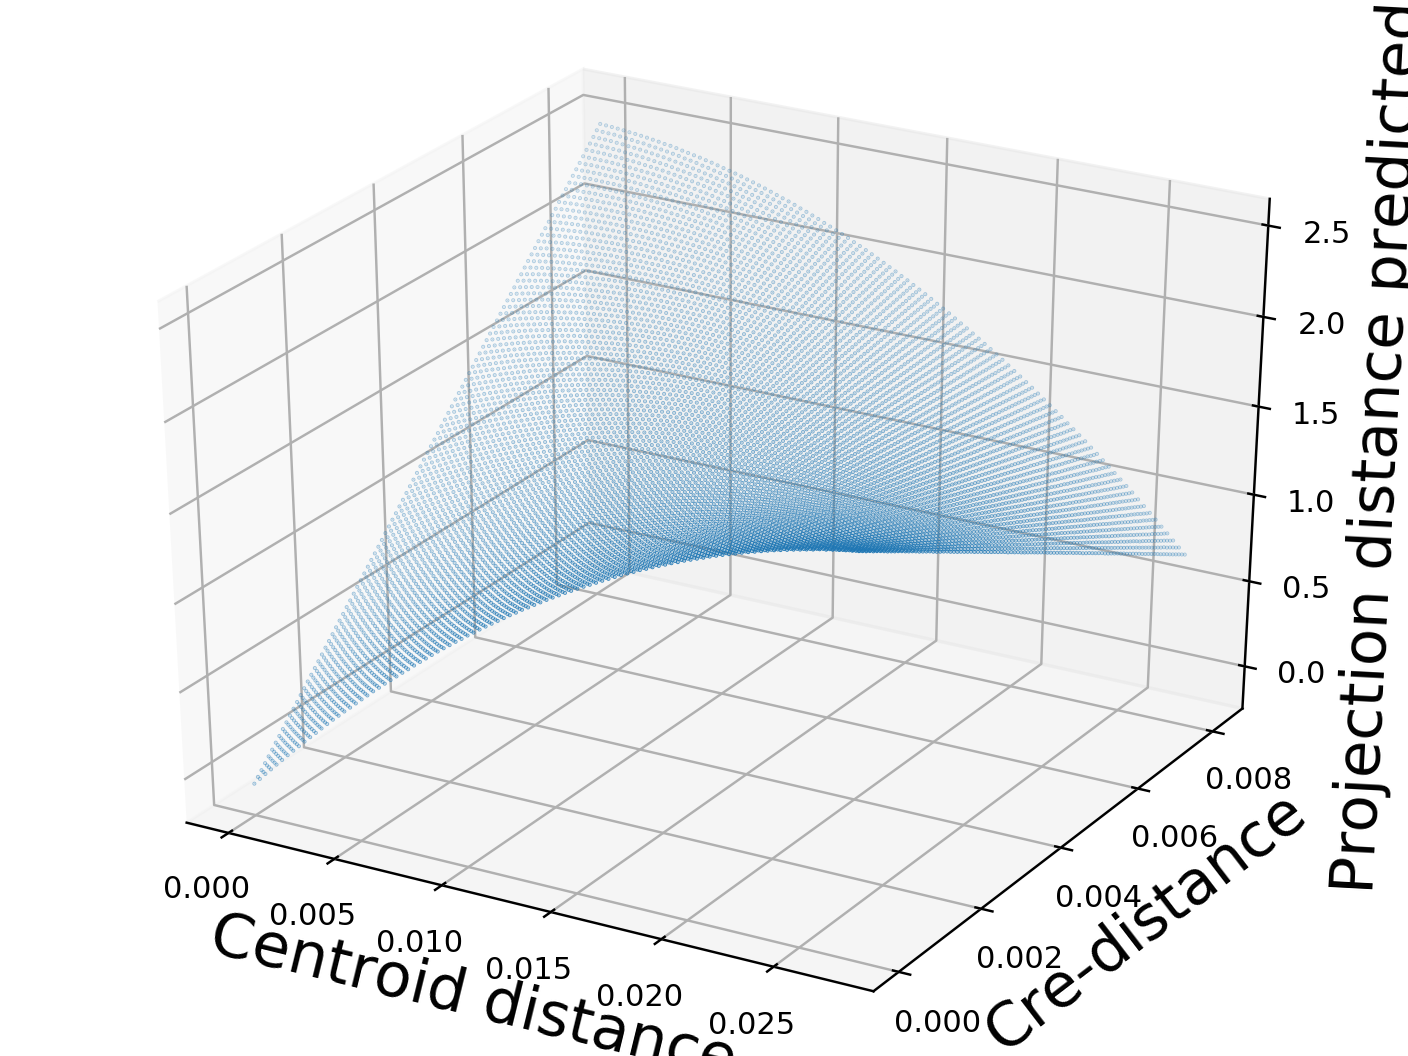

Text(0.5, 0, 'Projection distance predicted')

In [17]:
%matplotlib notebook
cs = cre_dist2
fraction = .01
#ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
nsamp = msvd.centroids.shape[0]
#need source and target color
source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
ngp = goodpairs.shape[0]
centroids = msvd.centroids
projs = msvd.reg_proj_vcount_norm_renorm
ds2 = np.zeros(ngp)
ls2 = np.zeros(ngp)
for i in range(ngp):
    #print(i)
    ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
    ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2

cs2 = cs[np.where(~np.isnan(cs))]    
#ds2 = ds[np.where(~np.isnan(cs))]
#
source2 = source[np.where(~np.isnan(cs.flatten()))]
target2 = target[np.where(~np.isnan(cs.flatten()))]

dsnorm  = np.linalg.norm(ds2)
csnorm = np.linalg.norm(cs2)

ds2 = ds2 / dsnorm
cs2 = cs2 / csnorm
#ls2 = ls[np.where(~np.isnan(cs))]

dc = np.asarray([ds2,cs2,ls2]).transpose()
#ids = np.linspace(0,35, 36, dtype = int), 36)

#qqq = NadarayaWatson(kernel='rbf',  gamma  = 100)
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
#qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
xs = np.linspace(0, dc[:,0].max(), 100)
ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((100,100))
for x in range(100):
    for y in range(100):
        preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(mxy[:,:,0], 
           mxy[:,:,1], 
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

In [215]:
# eminor = 91
# cre = 'C57BL/6J'
# crelines = creline[sid]
# exps = np.where(experiments_minor_structures[sid] == ia_map[eminor])[0]
# ems = experiments_minor_structures[sid][exps]
# nsamp = len(exps)
# #cres = np.unique(crelines)
# ncre  = len(cres)
# credist = np.empty((nsamp))
# im = Mask.from_cache(cache,
#     structure_ids=[eminor],
#     hemisphere_id=2)



# # for c in range(ncre):
# #     credist[c] = np.linalg.norm(means_cast.loc[tuple([cre, eminor])] - means_cast.loc[tuple([cres[j], eminors[j]])])

# # for j in range(nvox):
# #     minor_structure_inds = np.where(leafs[sid] == minor_structures[n])[0]
# #     cdist = np.linalg.norm(msvd.centroids[minor_structure_inds] - im.coordinates)



In [216]:
# nvox = im.coordinates.shape[0]
# #cdiff = np.zeros((nvox,nsamp,3))
# #cdist = np.zeros((nvox,nsamp))
# for i in range(nsamp):
#     cre_str = crelines[exps]
#     credist[i] = np.linalg.norm(means_cast.loc[tuple([cre, ia_map[eminor]])] - means_cast.loc[tuple([cre_str[i], ems[i]])])
    

# cdiff = np.asarray([(im.coordinates[j] - msvd.centroids[exps]) for j in range(nvox)])
# cdist = np.linalg.norm(cdiff, axis = 2)


In [232]:
# nexp = cdist.shape[1]
# pred_loss = np.zeros((nvox,nexp))
# for i in range(nvox):
#     for j in range(nexp):
#         cdiz = cdist[i,j] / dsnorm
#         crdiz = credist[j] / csnorm
#         pred_loss[i,j] = qqq.predict(np.asarray([[cdiz, crdiz]]))

In [154]:
crelines = creline[sid]
def get_crecent_loss(msvd, exps, means_cast, cre,crelines ,region,qqq):
    #cre = 'C57BL/6J'
    
    #exps = np.where(experiments_minor_structures[sid] == ia_map[region])[0]
    #ems = experiments_minor_structures[sid][exps]
    nsamp = len(exps)
    #cres = np.unique(crelines)
    #ncre  = len(cres)
    credist = np.empty((nsamp))
    im = Mask.from_cache(cache,
        structure_ids=[region],
        hemisphere_id=2)

    
    nvox = im.coordinates.shape[0]
    #cdiff = np.zeros((nvox,nsamp,3))
    #cdist = np.zeros((nvox,nsamp))
    cre_str = crelines[exps]
    for i in range(nsamp):
        print(i, 'get cre diff')
        credist[i] = np.linalg.norm(means_cast.loc[tuple([cre, ia_map[region]])] - means_cast.loc[tuple([cre_str[i], ia_map[ems[exps[i]]]])])

    cdiff = np.asarray([(im.coordinates[j] - msvd.centroids[exps]) for j in range(nvox)])
    cdist = np.linalg.norm(cdiff, axis = 2)
    nexp = cdist.shape[1]
    pred_loss = np.zeros((nvox,nexp))
    for i in range(nvox):
        print(i, 'get voxel loss')
        for j in range(nexp):
            cdiz = cdist[i,j] / dsnorm
            crdiz = credist[j] / csnorm
            pred_loss[i,j] = qqq.predict(np.asarray([[cdiz, crdiz]]))     
    return(pred_loss)

In [122]:
# from mcmodels.core.utils import get_ontological_order_leaf
# ontological_order_leaf = get_ontological_order_leaf(leafs, ontological_order, st)
# leafffs = [ia_map[ontological_order_leaf[i]] for i in range(ontological_order_leaf.shape[0])]

In [123]:
source_ordering = ontological_order#_leaf
prediction_union_norms = {}
source_region_save= np.asarray([])

In [124]:
# # weights = pairwise_kernels(X=msvds[sid].centroids[minor_structure_inds], Y=im.coordinates, metric='rbf',
# #                            gamma=gamma, filter_params=True)
# m = 0
# prediction_union_norms[m] = {}
# n = 0
# minor_structure_inds = exps
# losses = pred_loss
# gamma = .1
# weights = np.exp(-losses / gamma)
# weights = weights / weights.sum(axis=0)
# weights[np.where(np.isnan(weights))] = 0.
# predictions = np.dot(weights, msvds[sid].reg_proj_vcount_norm_renorm[minor_structure_inds])

# # average over source region voxels
# union_key = im.get_key(structure_ids=source_ordering, hemisphere_id=2)
# source_regions, source_counts = nonzero_unique(union_key, return_counts=True)
# prediction_union = unionize(predictions.transpose(), union_key)
# prediction_union_norms[m][n] = prediction_union.transpose() / np.expand_dims(source_counts, 1)
# source_region_save = np.append(source_region_save, source_regions)

# #np.argmin(pred_loss, axis = 1)

In [112]:
hyperparameters = 100*np.ones(12)

In [113]:
summms = [ia_map[ontological_order[i]] for i in range(ontological_order.shape[0])]

In [114]:
firstfour = np.asarray([name[:4] for name in summms])
#firstfour_col = np.asarray([name[:4] for name in colnames])

bs = np.where(np.isin(firstfour , ['VISp', 'VISl']))[0][:2]#[4:8]
#cs =  np.where(np.isin(firstfour , ['VISp', 'VISl']))[0]#[[0,1,2,3,4,36,37,38,39,40]]


In [115]:
np.asarray(summms)[bs]

array(['VISl', 'VISp'], dtype='<U7')

In [ ]:
            im = Mask.from_cache(
                cache,
                structure_ids=[minor_structures[n]],
                hemisphere_id=2)

In [137]:
ems = np.asarray([ai_map[experiments_minor_structures[sid][i]] for i in range(experiments_minor_structures[sid].shape[0])])

In [255]:
gamma = .001
hyperparameters
cres =  ['Cux2-IRES-Cre']
connectivity_data
source_ordering = ontological_order#ontological_order[bs]
target_ordering = 


In [284]:
    #cre = 'C57BL/6J'
    cre =  'Cux2-IRES-Cre'#'Ntsr1-Cre_GN220'#'Cux2-IRES-Cre'
    #cre = 'Tlx3-Cre_PL56'#'Rbp4-Cre_KL100' #'Cux2-IRES-Cre'
    # def get_connectivity(msvds, cache, ia_map, hyperparameters, source_ordering, target_ordering, leafs, creline,
    #                      experiments_minor_structures, ipsi_key, contra_key, cre_dist, cre = None):
    
    source_exp_countvec, source_exp_countvec_wt = get_countvec(source_ordering, ia_map, creline,
                                                               experiments_minor_structures)

    major_structure_ids = np.asarray(list(msvds.keys()))
    nms = len(major_structure_ids)
    prediction_union_norms = {}
    source_region_save = np.asarray([])

    for m in range(4,5):
        sid = major_structure_ids[m]
        #gamma = 1.#hyperparameters[m]
        minor_structures = source_ordering[np.where(np.isin(source_ordering, np.unique(ems)))]
        # ontological_order_leaf np.unique(leafs[sid]) # this should be in ontological order # np.unique(leafs[sid])#source_ordering[sid]#
        prediction_union_norms[m] = {}
        for n in range(len(minor_structures)):
            
            minor_structure_inds = np.where(ems == minor_structures[n])[0]
            print(n, minor_structures[n], len(minor_structure_inds))
            losses = get_crecent_loss(msvds[sid], minor_structure_inds, means_cast, cre,crelines ,minor_structures[n],qqq)
            im = Mask.from_cache(cache,
                structure_ids=[minor_structures[n]],
                hemisphere_id=2)  
            
            weights = np.exp( - losses / gamma)
            weights = weights / weights.sum(axis=0)
            weights[np.where(np.isnan(weights))] = 0.
            predictions = np.dot(weights, msvds[sid].reg_proj_vcount_norm_renorm[minor_structure_inds])

            # average over source region voxels
            union_key = im.get_key(structure_ids=source_ordering, hemisphere_id=2)
            source_regions, source_counts = nonzero_unique(union_key, return_counts=True)
            prediction_union = unionize(predictions.transpose(), union_key)
            prediction_union_norms[m][n] = prediction_union.transpose() / np.expand_dims(source_counts, 1)
            source_region_save = np.append(source_region_save, source_regions)


0 409 44
0 get cre diff
1 get cre diff
2 get cre diff
3 get cre diff
4 get cre diff
5 get cre diff
6 get cre diff
7 get cre diff
8 get cre diff
9 get cre diff
10 get cre diff
11 get cre diff
12 get cre diff
13 get cre diff
14 get cre diff
15 get cre diff
16 get cre diff
17 get cre diff
18 get cre diff
19 get cre diff
20 get cre diff
21 get cre diff
22 get cre diff
23 get cre diff
24 get cre diff
25 get cre diff
26 get cre diff
27 get cre diff
28 get cre diff
29 get cre diff
30 get cre diff
31 get cre diff
32 get cre diff
33 get cre diff
34 get cre diff
35 get cre diff
36 get cre diff
37 get cre diff
38 get cre diff
39 get cre diff
40 get cre diff
41 get cre diff
42 get cre diff
43 get cre diff
0 get voxel loss
1 get voxel loss
2 get voxel loss
3 get voxel loss
4 get voxel loss
5 get voxel loss
6 get voxel loss
7 get voxel loss
8 get voxel loss
9 get voxel loss
10 get voxel loss
11 get voxel loss
12 get voxel loss
13 get voxel loss
14 get voxel loss
15 get voxel loss
16 get voxel loss
1

412 get voxel loss
413 get voxel loss
414 get voxel loss
415 get voxel loss
416 get voxel loss
417 get voxel loss
418 get voxel loss
419 get voxel loss
420 get voxel loss
421 get voxel loss
422 get voxel loss
423 get voxel loss
424 get voxel loss
425 get voxel loss
426 get voxel loss
427 get voxel loss
428 get voxel loss
429 get voxel loss
430 get voxel loss
431 get voxel loss
432 get voxel loss
433 get voxel loss
434 get voxel loss
435 get voxel loss
436 get voxel loss
437 get voxel loss
438 get voxel loss
439 get voxel loss
440 get voxel loss
441 get voxel loss
442 get voxel loss
443 get voxel loss
444 get voxel loss
445 get voxel loss
446 get voxel loss
447 get voxel loss
448 get voxel loss
449 get voxel loss
450 get voxel loss
451 get voxel loss
452 get voxel loss
453 get voxel loss
454 get voxel loss
455 get voxel loss
456 get voxel loss
457 get voxel loss
458 get voxel loss
459 get voxel loss
460 get voxel loss
461 get voxel loss
462 get voxel loss
463 get voxel loss
464 get voxe

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


0 get cre diff
1 get cre diff
2 get cre diff
3 get cre diff
4 get cre diff
5 get cre diff
6 get cre diff
7 get cre diff
8 get cre diff
9 get cre diff
10 get cre diff
11 get cre diff
12 get cre diff
13 get cre diff
14 get cre diff
15 get cre diff
16 get cre diff
17 get cre diff
18 get cre diff
19 get cre diff
20 get cre diff
21 get cre diff
22 get cre diff
23 get cre diff
24 get cre diff
25 get cre diff
26 get cre diff
27 get cre diff
28 get cre diff
29 get cre diff
30 get cre diff
31 get cre diff
32 get cre diff
33 get cre diff
34 get cre diff
35 get cre diff
36 get cre diff
37 get cre diff
38 get cre diff
39 get cre diff
40 get cre diff
41 get cre diff
42 get cre diff
43 get cre diff
44 get cre diff
45 get cre diff
46 get cre diff
47 get cre diff
48 get cre diff
49 get cre diff
50 get cre diff
51 get cre diff
52 get cre diff
53 get cre diff
54 get cre diff
55 get cre diff
56 get cre diff
57 get cre diff
58 get cre diff
59 get cre diff
60 get cre diff
61 get cre diff
62 get cre diff
63

227 get voxel loss
228 get voxel loss
229 get voxel loss
230 get voxel loss
231 get voxel loss
232 get voxel loss
233 get voxel loss
234 get voxel loss
235 get voxel loss
236 get voxel loss
237 get voxel loss
238 get voxel loss
239 get voxel loss
240 get voxel loss
241 get voxel loss
242 get voxel loss
243 get voxel loss
244 get voxel loss
245 get voxel loss
246 get voxel loss
247 get voxel loss
248 get voxel loss
249 get voxel loss
250 get voxel loss
251 get voxel loss
252 get voxel loss
253 get voxel loss
254 get voxel loss
255 get voxel loss
256 get voxel loss
257 get voxel loss
258 get voxel loss
259 get voxel loss
260 get voxel loss
261 get voxel loss
262 get voxel loss
263 get voxel loss
264 get voxel loss
265 get voxel loss
266 get voxel loss
267 get voxel loss
268 get voxel loss
269 get voxel loss
270 get voxel loss
271 get voxel loss
272 get voxel loss
273 get voxel loss
274 get voxel loss
275 get voxel loss
276 get voxel loss
277 get voxel loss
278 get voxel loss
279 get voxe

659 get voxel loss
660 get voxel loss
661 get voxel loss
662 get voxel loss
663 get voxel loss
664 get voxel loss
665 get voxel loss
666 get voxel loss
667 get voxel loss
668 get voxel loss
669 get voxel loss
670 get voxel loss
671 get voxel loss
672 get voxel loss
673 get voxel loss
674 get voxel loss
675 get voxel loss
676 get voxel loss
677 get voxel loss
678 get voxel loss
679 get voxel loss
680 get voxel loss
681 get voxel loss
682 get voxel loss
683 get voxel loss
684 get voxel loss
685 get voxel loss
686 get voxel loss
687 get voxel loss
688 get voxel loss
689 get voxel loss
690 get voxel loss
691 get voxel loss
692 get voxel loss
693 get voxel loss
694 get voxel loss
695 get voxel loss
696 get voxel loss
697 get voxel loss
698 get voxel loss
699 get voxel loss
700 get voxel loss
701 get voxel loss
702 get voxel loss
703 get voxel loss
704 get voxel loss
705 get voxel loss
706 get voxel loss
707 get voxel loss
708 get voxel loss
709 get voxel loss
710 get voxel loss
711 get voxe

1087 get voxel loss
1088 get voxel loss
1089 get voxel loss
1090 get voxel loss
1091 get voxel loss
1092 get voxel loss
1093 get voxel loss
1094 get voxel loss
1095 get voxel loss
1096 get voxel loss
1097 get voxel loss
1098 get voxel loss
1099 get voxel loss
1100 get voxel loss
1101 get voxel loss
1102 get voxel loss
1103 get voxel loss
1104 get voxel loss
1105 get voxel loss
1106 get voxel loss
1107 get voxel loss
1108 get voxel loss
1109 get voxel loss
1110 get voxel loss
1111 get voxel loss
1112 get voxel loss
1113 get voxel loss
1114 get voxel loss
1115 get voxel loss
1116 get voxel loss
1117 get voxel loss
1118 get voxel loss
1119 get voxel loss
1120 get voxel loss
1121 get voxel loss
1122 get voxel loss
1123 get voxel loss
1124 get voxel loss
1125 get voxel loss
1126 get voxel loss
1127 get voxel loss
1128 get voxel loss
1129 get voxel loss
1130 get voxel loss
1131 get voxel loss
1132 get voxel loss
1133 get voxel loss
1134 get voxel loss
1135 get voxel loss
1136 get voxel loss


1497 get voxel loss
1498 get voxel loss
1499 get voxel loss
1500 get voxel loss
1501 get voxel loss
1502 get voxel loss
1503 get voxel loss
1504 get voxel loss
1505 get voxel loss
1506 get voxel loss
1507 get voxel loss
1508 get voxel loss
1509 get voxel loss
1510 get voxel loss
1511 get voxel loss
1512 get voxel loss
1513 get voxel loss
1514 get voxel loss
1515 get voxel loss
1516 get voxel loss
1517 get voxel loss
1518 get voxel loss
1519 get voxel loss
1520 get voxel loss
1521 get voxel loss
1522 get voxel loss
1523 get voxel loss
1524 get voxel loss
1525 get voxel loss
1526 get voxel loss
1527 get voxel loss
1528 get voxel loss
1529 get voxel loss
1530 get voxel loss
1531 get voxel loss
1532 get voxel loss
1533 get voxel loss
1534 get voxel loss
1535 get voxel loss
1536 get voxel loss
1537 get voxel loss
1538 get voxel loss
1539 get voxel loss
1540 get voxel loss
1541 get voxel loss
1542 get voxel loss
1543 get voxel loss
1544 get voxel loss
1545 get voxel loss
1546 get voxel loss


1909 get voxel loss
1910 get voxel loss
1911 get voxel loss
1912 get voxel loss
1913 get voxel loss
1914 get voxel loss
1915 get voxel loss
1916 get voxel loss
1917 get voxel loss
1918 get voxel loss
1919 get voxel loss
1920 get voxel loss
1921 get voxel loss
1922 get voxel loss
1923 get voxel loss
1924 get voxel loss
1925 get voxel loss
1926 get voxel loss
1927 get voxel loss
1928 get voxel loss
1929 get voxel loss
1930 get voxel loss
1931 get voxel loss
1932 get voxel loss
1933 get voxel loss
1934 get voxel loss
1935 get voxel loss
1936 get voxel loss
1937 get voxel loss
1938 get voxel loss
1939 get voxel loss
1940 get voxel loss
1941 get voxel loss
1942 get voxel loss
1943 get voxel loss
1944 get voxel loss
1945 get voxel loss
1946 get voxel loss
1947 get voxel loss
1948 get voxel loss
1949 get voxel loss
1950 get voxel loss
1951 get voxel loss
1952 get voxel loss
1953 get voxel loss
1954 get voxel loss
1955 get voxel loss
1956 get voxel loss
1957 get voxel loss
1958 get voxel loss


2319 get voxel loss
2320 get voxel loss
2321 get voxel loss
2322 get voxel loss
2323 get voxel loss
2324 get voxel loss
2325 get voxel loss
2326 get voxel loss
2327 get voxel loss
2328 get voxel loss
2329 get voxel loss
2330 get voxel loss
2331 get voxel loss
2332 get voxel loss
2333 get voxel loss
2334 get voxel loss
2335 get voxel loss
2336 get voxel loss
2337 get voxel loss
2338 get voxel loss
2339 get voxel loss
2340 get voxel loss
2341 get voxel loss
2342 get voxel loss
2343 get voxel loss
2344 get voxel loss
2345 get voxel loss
2346 get voxel loss
2347 get voxel loss
2348 get voxel loss
2349 get voxel loss
2350 get voxel loss
2351 get voxel loss
2352 get voxel loss
2353 get voxel loss
2354 get voxel loss
2355 get voxel loss
2356 get voxel loss
2357 get voxel loss
2358 get voxel loss
2359 get voxel loss
2360 get voxel loss
2361 get voxel loss
2362 get voxel loss
2363 get voxel loss
2364 get voxel loss
2365 get voxel loss
2366 get voxel loss
2367 get voxel loss
2368 get voxel loss


2730 get voxel loss
2731 get voxel loss
2732 get voxel loss
2733 get voxel loss
2734 get voxel loss
2735 get voxel loss
2736 get voxel loss
2737 get voxel loss
2738 get voxel loss
2739 get voxel loss
2740 get voxel loss
2741 get voxel loss
2742 get voxel loss
2743 get voxel loss
2744 get voxel loss
2745 get voxel loss
2746 get voxel loss
2747 get voxel loss
2748 get voxel loss
2749 get voxel loss
2750 get voxel loss
2751 get voxel loss
2752 get voxel loss
2753 get voxel loss
2754 get voxel loss
2755 get voxel loss
2756 get voxel loss
2757 get voxel loss
2758 get voxel loss
2759 get voxel loss
2760 get voxel loss
2761 get voxel loss
2762 get voxel loss
2763 get voxel loss
2764 get voxel loss
2765 get voxel loss
2766 get voxel loss
2767 get voxel loss
2768 get voxel loss
2769 get voxel loss
2770 get voxel loss
2771 get voxel loss
2772 get voxel loss
2773 get voxel loss
2774 get voxel loss
2775 get voxel loss
2776 get voxel loss
2777 get voxel loss
2778 get voxel loss
2779 get voxel loss


3141 get voxel loss
3142 get voxel loss
3143 get voxel loss
3144 get voxel loss
3145 get voxel loss
3146 get voxel loss
3147 get voxel loss
3148 get voxel loss
3149 get voxel loss
3150 get voxel loss
3151 get voxel loss
3152 get voxel loss
3153 get voxel loss
3154 get voxel loss
3155 get voxel loss
3156 get voxel loss
3157 get voxel loss
3158 get voxel loss
3159 get voxel loss
3160 get voxel loss
3161 get voxel loss
3162 get voxel loss
3163 get voxel loss
3164 get voxel loss
3165 get voxel loss
3166 get voxel loss
3167 get voxel loss
3168 get voxel loss
3169 get voxel loss
3170 get voxel loss
3171 get voxel loss
3172 get voxel loss
3173 get voxel loss
3174 get voxel loss
3175 get voxel loss
3176 get voxel loss
3177 get voxel loss
3178 get voxel loss
3179 get voxel loss
3180 get voxel loss
3181 get voxel loss
3182 get voxel loss
3183 get voxel loss
3184 get voxel loss
3185 get voxel loss
3186 get voxel loss
3187 get voxel loss
3188 get voxel loss
3189 get voxel loss
3190 get voxel loss


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [285]:
leavves = get_leaves_ontologicalorder(msvd, ontological_order)
key = list(msvd.experiments.keys())[0]
contra_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

# contra_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=1)
# ipsi_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=2)
target_ordering = ontological_order

In [286]:

    prediction_union_norms_ms = {}
    for m in range(4,5):
        prediction_union_norms_ms[m] = np.vstack(
            [prediction_union_norms[m][n] for n in range(len(prediction_union_norms[m].keys()))])

    cd = np.vstack([prediction_union_norms_ms[m] for m in range(4,5)])

    # get row names
    rownames = [ia_map[source_ordering[i]] for i in range(len(source_ordering))]
    # rownames = np.asarray(rownames)[np.where(source_exp_countvec !=0)[0]]

    # get column names
    ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
    contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
    target_order = lambda x: np.array(target_ordering)[np.isin(target_ordering, x)]
    permutation = lambda x: np.argsort(np.argsort(target_order(x)))
    targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                               contra_target_regions[permutation(contra_target_regions)]])
    colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])


In [287]:

    # reorder rows and columns
    targ_ords = np.concatenate(
        [permutation(ipsi_target_regions), len(ipsi_target_regions) + permutation(contra_target_regions)])
    row_reorder = np.asarray([])
    source_region_save = np.asarray(source_region_save, dtype=int)
    for i in range(len(source_ordering)):
        inx = np.where(source_region_save == int(source_ordering[i]))[0]
        if len(inx) > 0:
            row_reorder = np.append(row_reorder, inx)
    row_reorder = np.asarray(row_reorder, dtype=int)

    df = pd.DataFrame(cd[row_reorder][:, targ_ords], index=rownames, columns=np.asarray(colnames))
    #return (df)

In [288]:
df.to_csv('/Users/samsonkoelle/vislvisp_Cux2-IRES-Cre.csv')
#df.to_csv('/Users/samsonkoelle/Tlx3-Cre_PL56.csv')
#df.to_csv('/Users/samsonkoelle/vislvisp_Rbp4-Cre_KL100.csv')
#df.to_csv('/Users/samsonkoelle/Ntsr1-Cre_GN220.csv')

In [176]:
cd.shape

(2, 577)

In [ ]:
plt.imshow(df)

In [142]:
n  =1
im = Mask.from_cache(cache,
    structure_ids=[minor_structures[n]],
    hemisphere_id=2)  
minor_structure_inds = np.where(ems == minor_structures[n])[0]
msvd = msvds[sid]
exps = minor_structure_inds
region = minor_structures[n]       

In [152]:
    nsamp = len(exps)
    #cres = np.unique(crelines)
    #ncre  = len(cres)
    credist = np.empty((nsamp))
    im = Mask.from_cache(cache,
        structure_ids=[region],
        hemisphere_id=2)
    
    nvox = im.coordinates.shape[0]
    #cdiff = np.zeros((nvox,nsamp,3))
    #cdist = np.zeros((nvox,nsamp))
    cre_str = crelines[exps]
    for i in range(nsamp):
        print(i)
        credist[i] = np.linalg.norm(means_cast.loc[tuple([cre, ia_map[region]])] - means_cast.loc[tuple([cre_str[i], ia_map[ems[exps[i]]]])])
    
#    cdif = np.asarray([])
#     for j in range(nvox):
#         print(j)
#         cdif = np.append(cdif, im.coordinates[j] - msvd.centroids[exps])
#     cdiff = np.asarray(cdif)
    cdiff = np.asarray([(im.coordinates[j] - msvd.centroids[exps]) for j in range(nvox)])
    cdist = np.linalg.norm(cdiff, axis = 2)
    nexp = cdist.shape[1]
    pred_loss = np.zeros((nvox,nexp))
    for i in range(nvox):
        print(i)
        for j in range(nexp):
            cdiz = cdist[i,j] / dsnorm
            crdiz = credist[j] / csnorm
            pred_loss[i,j] = qqq.predict(np.asarray([[cdiz, crdiz]]))   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


KeyboardInterrupt: 

In [151]:
cdiff.shape

(2597136,)

In [149]:
nvox

3548

In [118]:
qqq.predict(np.asarray([[cdiz, crdiz]]))   

array([[0.60186768]])

In [120]:
pred_loss.shape

(619, 44)

In [48]:
cre_subset = np.asarray(['Cux2-IRES-Cre', 'Ntsr1-Cre_GN220', 'Rbp4-Cre_KL100', 'Tlx3-Cre_PL56'])

In [ ]:
#sometimes there are none of the desired cre line in the region.... in this case we shouldn't use them to make the prediction

In [330]:
def get_nwloocv_predictions_multimodel_merge_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

In [331]:
sid

512

In [335]:
from sklearn.metrics.pairwise import pairwise_kernels
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)

#get where we actually modelled
def get_eval_indices(eval_index_matrices):
    eval_indices = {}
    major_structure_ids = np.asarray(list(eval_index_matrices.keys()))
    for sid in major_structure_ids:
        eval_indices[sid] = np.where(eval_index_matrices[sid].sum(axis = 0) > 0)[0]
    return(eval_indices)    



def get_weights(eval_centroids, model_centroids, gamma):
    weights = pairwise_kernels(X=eval_centroids, Y=model_centroids, metric='rbf', gamma=gamma, filter_params=True)
    return (weights)


def get_indices(ids):

    ids_unique = np.unique(ids)
    output = np.zeros((len(ids_unique), len(ids)), dtype = int)
    for i in range(len(ids_unique)):
        output[i,np.where(ids == ids_unique[i])[0] ] = 1
    return(output)

#get indices of firstlist in firstlisttest in categories defined by secondlist
def get_indices2(firstlist, firstlisttest, secondlist):
    
    sl_unique = np.unique(secondlist)
    output = np.zeros((len(sl_unique), len(secondlist)), dtype = int)
    for i in range(len(sl_unique)):
        output[i,np.intersect1d(np.where(np.isin(firstlist,firstlisttest))[0], np.where(secondlist == sl_unique[i])[0])] = 1
    return(output)

#nmodels = nleafs
#populate each with experiments that share summary structure
def get_indices_summaryinleaf(summarylist , leaflist):
    
    nexp = len(leaflist)
    leaf_unique = np.unique(leaflist)
    output = np.zeros((len(leaf_unique), nexp), dtype = int)
    
    for i in range(len(leaf_unique)):
        
        summary = summarylist[np.where(leaflist == leaf_unique[i])[0]][0]
        output[i,np.where(summarylist == summary)[0]] = 1
        
        
    return(output)

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices
def screen_indices(model_indices, eval_indices):
    
    eval_indices2 = eval_indices.copy()
    mod_loc = np.where(model_indices == 1)[0]
    if len(mod_loc) == 1:
        eval_indices2[mod_loc] = 0
    return(eval_indices2)

#this could result in an empty eval index i.e. certain indices having no prediction.  catch later
#can merge (sum) the index matrix to see where predictions are actually generated
def screen_index_matrices(model_index_matrices, eval_index_matrices):
    
    #alter eval_indices to remove model index in cases where there is only one experiment in the model
    
    nmodels = model_index_matrices.shape[0]
    eval_index_matrices2 = eval_index_matrices.copy()
    for m in range(nmodels):
        eval_index_matrices2[m] = screen_indices(model_index_matrices[m], eval_index_matrices[m])
    
    return(eval_index_matrices2)

#need code for removing experiments that have no model
#this can happen when the model set is a subset of the evaluation set.
#we will therefore generate predictions for a subset
#given a leaf is included, the eval set is the same
#however, we want to remove evals in leaves we don't have a wt for... of course one could say we are doing worse...
#but we also have a fewer number of models
#model_index_matrices are the indices of the leafs'
#indices_wtinleaf are the wild types
#need to make sure we dont have leafs with only 1 experiment


def screen_index_matrices2(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model <= 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def screen_index_matrices3(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least one experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model < 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    to_remove = np.where(include_per_model == 1)[0]
    eval_index_matrices2[to_remove] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def get_cre_similarity(msvd, cres,eminors,colnames):

    ss = np.append(['cre','injsum'],colnames)
    ns = np.concatenate([np.empty(2, dtype = str), np.repeat('ipsi',291), np.repeat('contra',286)])
    colns = np.vstack([ns,ss]).transpose()
    clns = list(zip(*colns.transpose()))
    clnsmi = pd.MultiIndex.from_tuples(clns, names=['first', 'second'])
    data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),msvd.reg_proj_vcount_norm_renorm ]), columns= clnsmi)
    data_melted = pd.melt(data_merged, id_vars=[('','cre'),('','injsum')])
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['first', 'second',('','cre'),('','injsum')])['value'].mean().reset_index()
    means = means.astype({'value': np.float64})
    means_cast = pd.pivot_table(means, index = [('','cre'),('','injsum')], columns = ['first', 'second'])
    cs = np.asarray(list(means_cast.index))    
    return(means_cast,cs)

In [336]:
indices_leaf = {}
indices_wtinleaf = {}
indices_wtleaf = {}
indices_summary = {}
indices_summaryinleaf = {}
indices_major = {}
indices_majorinleaf = {}
indices_leaf2ormore = {}
indices_wtinleaf2ormore = {}
indices_leaf_reduced = {}
indices_wtinleaf_reduced = {}
indices_wt_leaf2ormore = {}
indices_leaf2ormore_wt = {}
indices_wt1ormore_leaf2ormore = {}
indices_leaf2ormore_wt1ormore = {}
for sid in major_structure_ids:
    
    #wt_leaf on leaf

    #get the indices of experiments sharing leafs (nmodels is number of leafs)
    indices_leaf[sid] = get_indices(leafs[sid]) #eval_indices
    #indices_creleaf = get_indices(leafs[sid])
    
    #get the indices of the wts in the leaf (nmodels is number of leafs)
    indices_wtinleaf[sid] = get_indices2(creline[sid], np.asarray(['C57BL/6J']),leafs[sid]) #model_indices
    
    #get indices of experiments sharing summary structure x cre combination (nmodel is number of cre x leaf combinations)
    #indices_wtleaf[sid] = get_indices(creleafs_merged[sid])
    
    #get indices of experiments sharing summary structure(nmodel is number of summary structures)
    indices_summary[sid] = get_indices(experiments_minor_structures[sid])
    
    #get indices of experiments sharing major structure(nmodel is number of summary structures)
    indices_major[sid] = np.ones((1,experiments_minor_structures[sid].shape[0]))
    
    #get indices of experiments sharing same major structure as a leaf (nmodel is number of leafs)
    indices_majorinleaf[sid] = np.ones((len(np.unique(leafs[sid])),experiments_minor_structures[sid].shape[0]))#get_indices2(np.ones(len(leafs[sid])), np.asarray([1]),leafs[sid]) #model_indices
    
    #get indices of experiments in same summary structure as a leaf (nmodel is number of leafs)
    indices_summaryinleaf[sid] = get_indices_summaryinleaf(experiments_minor_structures[sid], leafs[sid])
    
    #evaluate models on leafs
    indices_leaf2ormore[sid] = screen_index_matrices(indices_leaf[sid], indices_leaf[sid])
    
    indices_wt1ormore_leaf2ormore[sid], indices_leaf2ormore_wt1ormore[sid] = screen_index_matrices3(indices_wtinleaf[sid], indices_leaf2ormore[sid])
    
    indices_wtinleaf2ormore[sid] = screen_index_matrices(indices_wtinleaf[sid], indices_wtinleaf[sid])
    indices_leaf_reduced[sid], indices_wtinleaf_reduced[sid]  = screen_index_matrices2( indices_leaf2ormore[sid],indices_wtinleaf[sid])


In [23]:

qqqs = {}
for m in range(1):
    sid = major_structure_ids[m]#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
    print(sid)
    msvd = msvds[sid]
    cres = creline[sid]
    eminors = experiments_minor_structures[sid]
    means_cast, cs = get_cre_similarity(msvd, cres,eminors, colnames)
    #mean_dist = get_mean_dist(means_cast)
    cre_dist2 = get_cre_dist_cv(msvd, means_cast, eminors,cres)
    qqqs[sid] = get_loss_surface(msvd, cre_dist2,frac_learn[m])
    sls[sid] = get_smoothed_losses(msvd,qqqs[sid][0], cre_dist2)

512
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


In [ ]:
def get_cre_dist_cv(msvd, means_cast, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])]
        ncr = len(np.where(cres == cres[i])[0])
        meanloocvi = meani
        meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

In [28]:
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])] #what is the mean of the cre line in this leaf
        #ncr = len(np.where(cres == cres[i])[0]) #where are the cres in this major structure
        #thi should be intersect leaf
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(msvd.reg_proj_vcount_norm_renorm[i].shape[0])
        print(meanloocvi.max(), 'max', ncr)
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)


0
0.0 max 1
1
0.0 max 1
2
0.0 max 1
3
0.0 max 1
4
0.0 max 1
5
0.0 max 1
6
0.0 max 1
7
1.7320537173479744 max 2
8
0.0 max 1
9
0.0 max 1
10
0.0 max 1
11
1.8132865844498063 max 2
12
0.0 max 1
13
0.0 max 1
14
0.0 max 1
15
0.0 max 1
16
0.0 max 1
17
0.0 max 1
18
0.0 max 1
19
0.0 max 1
20
0.0 max 1
21
1.8140395653100532 max 2
22
0.0 max 1
23
0.0 max 1
24
0.0 max 1
25
0.0 max 1
26
0.0 max 1
27
0.0 max 1
28
0.0 max 1
29
0.0 max 1
30
0.0 max 1
31
1.7320537173479744 max 2
32
0.0 max 1
33
0.0 max 1
34
0.0 max 1
35
0.0 max 1


In [29]:
credist

array([[1.        ,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.81763599,        nan, ..., 1.        ,        nan,
               nan],
       [       nan,        nan, 1.        , ...,        nan, 1.        ,
               nan],
       ...,
       [       nan, 0.81763599,        nan, ..., 1.        ,        nan,
               nan],
       [       nan,        nan, 1.        , ...,        nan, 1.        ,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
        1.        ]])

In [31]:
credist

array([[1.        ,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.81763599,        nan, ..., 1.        ,        nan,
               nan],
       [       nan,        nan, 1.        , ...,        nan, 1.        ,
               nan],
       ...,
       [       nan, 0.81763599,        nan, ..., 1.        ,        nan,
               nan],
       [       nan,        nan, 1.        , ...,        nan, 1.        ,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
        1.        ]])

In [32]:
cre_dist2

array([[0.11583756,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.3698315 ,        nan, ..., 1.31041104,        nan,
               nan],
       [       nan,        nan, 1.11711007, ...,        nan, 1.47158246,
               nan],
       ...,
       [       nan, 2.03268737,        nan, ..., 1.11390734,        nan,
               nan],
       [       nan,        nan, 1.47306877, ...,        nan, 1.11801457,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
        0.12109179]])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


In [218]:
from itertools import product

In [219]:
cdist.shape #the distance to each centroid
            #should be another same size cre dist replicate

(428, 3)

In [48]:
from mcmodels.regressors import NadarayaWatson

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161


<IPython.core.display.Javascript object>


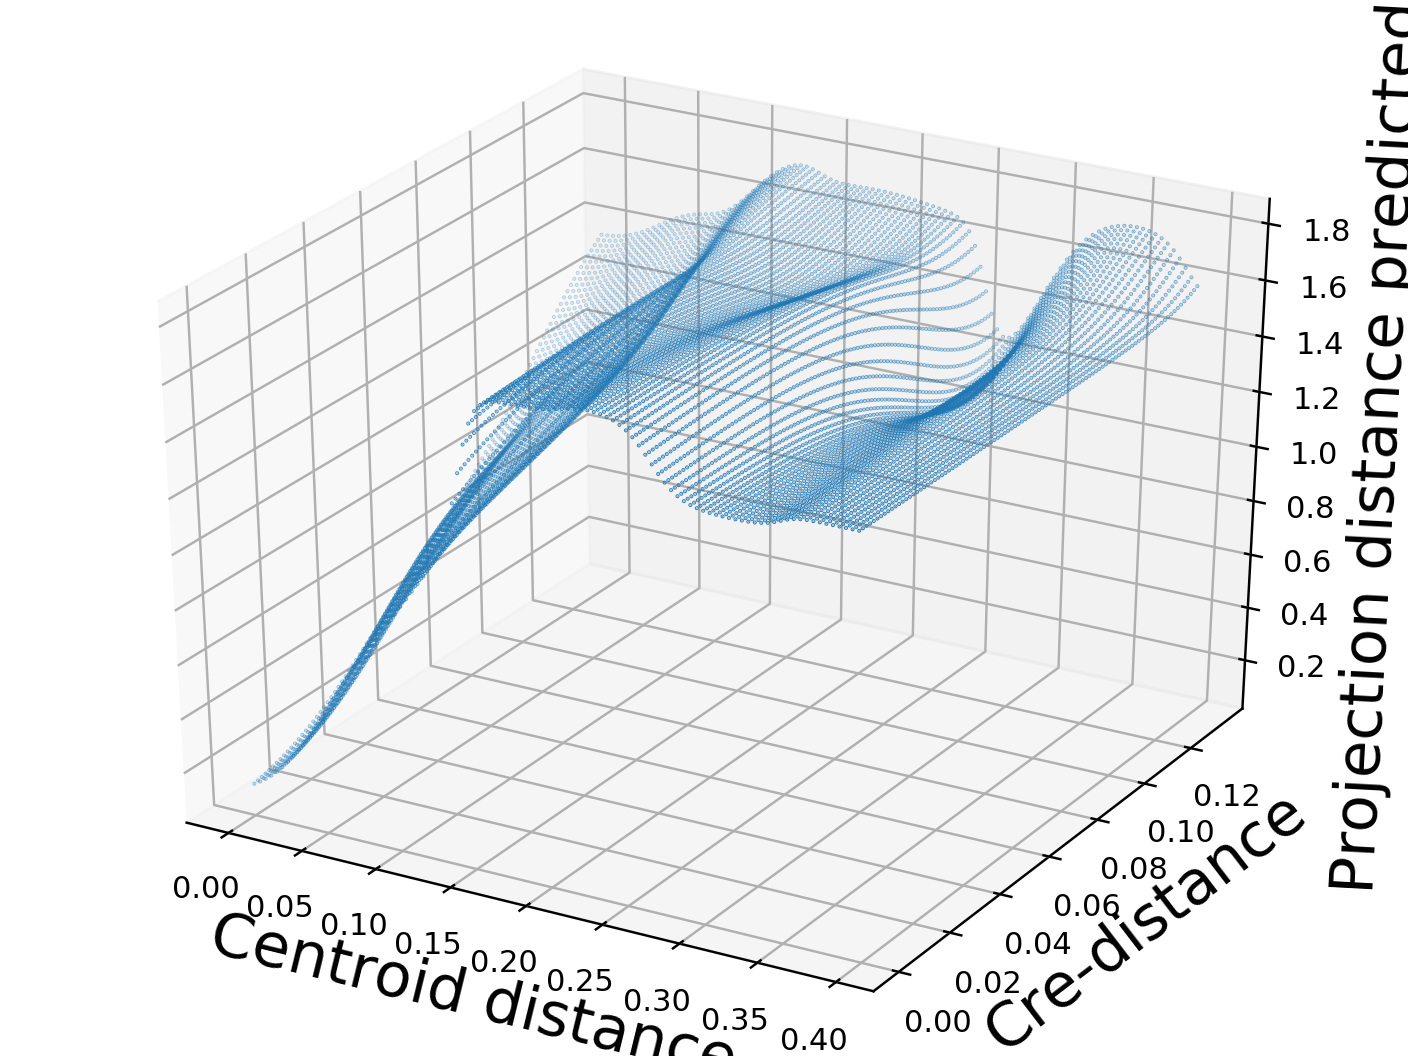

Text(0.5, 0, 'Projection distance predicted')

In [221]:
%matplotlib notebook
cs = cre_dist2
fraction = 1.
#ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
nsamp = msvd.centroids.shape[0]
#need source and target color
source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
ngp = goodpairs.shape[0]
centroids = msvd.centroids
projs = msvd.reg_proj_vcount_norm_renorm
ds2 = np.zeros(ngp)
ls2 = np.zeros(ngp)
for i in range(ngp):
    print(i)
    ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
    ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2

cs2 = cs[np.where(~np.isnan(cs))]    
#ds2 = ds[np.where(~np.isnan(cs))]
#
source2 = source[np.where(~np.isnan(cs.flatten()))]
target2 = target[np.where(~np.isnan(cs.flatten()))]

dsnorm  = np.linalg.norm(ds2)
csnorm = np.linalg.norm(cs2)

ds2 = ds2 / dsnorm
cs2 = cs2 / csnorm
#ls2 = ls[np.where(~np.isnan(cs))]

dc = np.asarray([ds2,cs2,ls2]).transpose()
#ids = np.linspace(0,35, 36, dtype = int), 36)

#qqq = NadarayaWatson(kernel='rbf',  gamma  = 100)
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
#qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
xs = np.linspace(0, dc[:,0].max(), 100)
ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((100,100))
for x in range(100):
    for y in range(100):
        preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(mxy[:,:,0], 
           mxy[:,:,1], 
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

In [41]:
cre_dist2

array([[0.11583756,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.3698315 ,        nan, ..., 1.31041104,        nan,
               nan],
       [       nan,        nan, 1.11711007, ...,        nan, 1.47158246,
               nan],
       ...,
       [       nan, 2.03268737,        nan, ..., 1.11390734,        nan,
               nan],
       [       nan,        nan, 1.47306877, ...,        nan, 1.11801457,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
        0.12109179]])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161


<IPython.core.display.Javascript object>


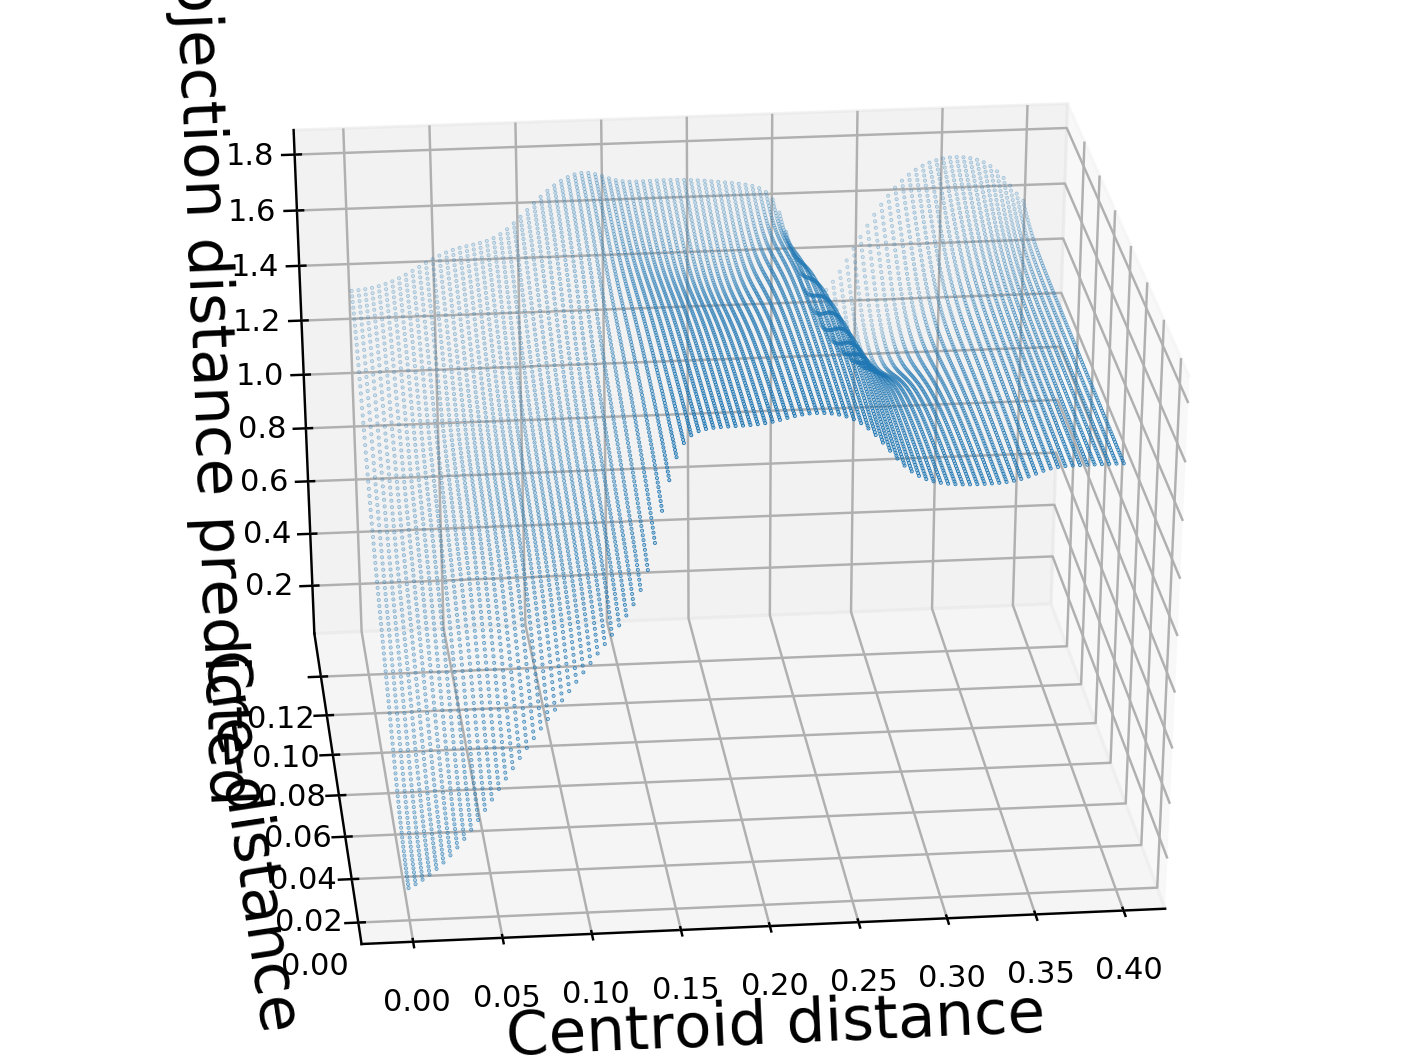

Text(0.5, 0, 'Projection distance predicted')

In [49]:
%matplotlib notebook
msvd = msvds[512]
cs = cre_dist2
fraction = 1.
#ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
nsamp = msvd.centroids.shape[0]
#need source and target color
source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
ngp = goodpairs.shape[0]
centroids = msvd.centroids
projs = msvd.reg_proj_vcount_norm_renorm
ds2 = np.zeros(ngp)
ls2 = np.zeros(ngp)
for i in range(ngp):
    print(i)
    ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
    ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2

cs2 = cs[np.where(~np.isnan(cs))]    
#ds2 = ds[np.where(~np.isnan(cs))]
#
source2 = source[np.where(~np.isnan(cs.flatten()))]
target2 = target[np.where(~np.isnan(cs.flatten()))]

dsnorm  = np.linalg.norm(ds2)
csnorm = np.linalg.norm(cs2)

ds2 = ds2 / dsnorm
cs2 = cs2 / csnorm

dc = np.asarray([ds2,cs2,ls2]).transpose()

qqq = NadarayaWatson(kernel='rbf',  gamma  = 1000)
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
qqq.fit(dc[:,:2][randos], dc[:,2:][randos])

# qqq = KernelRidge(kernel='rbf', alpha=0., gamma  = .005)
# randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
# qqq.fit(dc[:,:2][randos], dc[:,2:][randos])

xs = np.linspace(0, dc[:,0].max(), 100)
ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((100,100))
for x in range(100):
    for y in range(100):
        preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(mxy[:,:,0], 
           mxy[:,:,1], 
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

In [38]:
help(KernelRidge)

Help on class KernelRidge in module sklearn.kernel_ridge:

class KernelRidge(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, sklearn.base.BaseEstimator)
 |  KernelRidge(alpha=1, kernel='linear', gamma=None, degree=3, coef0=1, kernel_params=None)
 |  
 |  Kernel ridge regression.
 |  
 |  Kernel ridge regression (KRR) combines ridge regression (linear least
 |  squares with l2-norm regularization) with the kernel trick. It thus
 |  learns a linear function in the space induced by the respective kernel and
 |  the data. For non-linear kernels, this corresponds to a non-linear
 |  function in the original space.
 |  
 |  The form of the model learned by KRR is identical to support vector
 |  regression (SVR). However, different loss functions are used: KRR uses
 |  squared error loss while support vector regression uses epsilon-insensitive
 |  loss, both combined with l2 regularization. In contrast to SVR, fitting a
 |  KRR model can be done in closed-form and is typically fas

In [102]:
import sklearn
help(sklearn.metrics.pairwise)

Help on module sklearn.metrics.pairwise in sklearn.metrics:

NAME
    sklearn.metrics.pairwise - # -*- coding: utf-8 -*-

FUNCTIONS
    additive_chi2_kernel(X, Y=None)
        Computes the additive chi-squared kernel between observations in X and Y
        
        The chi-squared kernel is computed between each pair of rows in X and Y.  X
        and Y have to be non-negative. This kernel is most commonly applied to
        histograms.
        
        The chi-squared kernel is given by::
        
            k(x, y) = -Sum [(x - y)^2 / (x + y)]
        
        It can be interpreted as a weighted difference per entry.
        
        Read more in the :ref:`User Guide <chi2_kernel>`.
        
        Notes
        -----
        As the negative of a distance, this kernel is only conditionally positive
        definite.
        
        
        Parameters
        ----------
        X : array-like of shape (n_samples_X, n_features)
        
        Y : array of shape (n_samples_Y, n_fe

In [ ]:

def get_predictions(msvd, losses):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)
    inds = get_inds(model_index_val, eval_index_val)
    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-losses[inds] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

In [ ]:

def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

In [ ]:
def regionalize_cre_line(msvds, creline):
    
    

In [7]:
from itertools import product

In [ ]:
def get_cre_dist(msvd, crelines, means_cast, eminor,cre):
    nsamp = cres.shape[0]
    
    cres = np.unique(crelines)
    ncre  = len(cres)
    credist = np.empty((ncre))
    
    for c in range(ncre):
        credist[c] = np.linalg.norm(means_cast.loc[tuple([cre, eminor])] - means_cast.loc[tuple([cres[j], eminors[j]])])
    
    for j in range(nvox):
        minor_structure_inds = np.where(leafs[sid] == minor_structures[n])[0]
        cdist = np.linalg.norm(msvd.centroids[minor_structure_inds] - im.coordinates)
        
    
    product(credist, cdist)
    qqq.predict()
            #get mean of all points sharing cre line and minor structure with this one (but not including)
            meani = 
            ncr = len(np.where(cres == cres[i])[0])
            meanloocvi = meani
            meanloocvi = #(ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
            #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
            meanj = 
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

In [ ]:
def get_expected_losses(msvd, qqq, creline, im.coordinates, cre):
    credist = 
    qqq.predict()

In [ ]:

def get_connectivity(msvds, cache, ia_map, hyperparameters, source_ordering, target_ordering, leafs, creline,
                     experiments_minor_structures, ipsi_key, contra_key, cre_dist, cre = None):

    source_exp_countvec, source_exp_countvec_wt = get_countvec(source_ordering, ia_map, creline,
                                                               experiments_minor_structures)

    major_structure_ids = np.asarray(list(msvds.keys()))
    nms = len(major_structure_ids)
    prediction_union_norms = {}
    source_region_save = np.asarray([])

    for m in range(nms):
        sid = major_structure_ids[m]
        gamma = hyperparameters[m]
        minor_structures = source_ordering[np.where(np.isin(source_ordering, np.unique(leafs[sid])))]
        # ontological_order_leaf np.unique(leafs[sid]) # this should be in ontological order # np.unique(leafs[sid])#source_ordering[sid]#
        prediction_union_norms[m] = {}
        for n in range(len(minor_structures)):
            print(n)
            minor_structure_inds = np.where(leafs[sid] == minor_structures[n])[0]
            # meezy = minor_structures[n]
            im = Mask.from_cache(
                cache,
                structure_ids=[minor_structures[n]],
                hemisphere_id=2)
            weights = pairwise_kernels(X=msvds[sid].centroids[minor_structure_inds], Y=im.coordinates, metric='rbf',
                                       gamma=gamma, filter_params=True)
            weights = weights / weights.sum(axis=0)
            weights[np.where(np.isnan(weights))] = 0.
            predictions = np.dot(weights.transpose(), msvds[sid].reg_proj_vcount_norm_renorm[minor_structure_inds])

            # average over source region voxels
            union_key = im.get_key(structure_ids=source_ordering, hemisphere_id=2)
            source_regions, source_counts = nonzero_unique(union_key, return_counts=True)
            prediction_union = unionize(predictions.transpose(), union_key)
            prediction_union_norms[m][n] = prediction_union.transpose() / np.expand_dims(source_counts, 1)
            source_region_save = np.append(source_region_save, source_regions)

    prediction_union_norms_ms = {}
    for m in range(nms):
        prediction_union_norms_ms[m] = np.vstack(
            [prediction_union_norms[m][n] for n in range(len(prediction_union_norms[m].keys()))])

    cd = np.vstack([prediction_union_norms_ms[m] for m in range(len(prediction_union_norms_ms.keys()))])

    # get row names
    rownames = [ia_map[source_ordering[i]] for i in range(len(source_ordering))]
    # rownames = np.asarray(rownames)[np.where(source_exp_countvec !=0)[0]]

    # get column names
    ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
    contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
    target_order = lambda x: np.array(target_ordering)[np.isin(target_ordering, x)]
    permutation = lambda x: np.argsort(np.argsort(target_order(x)))
    targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                               contra_target_regions[permutation(contra_target_regions)]])
    colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

    # reorder rows and columns
    targ_ords = np.concatenate(
        [permutation(ipsi_target_regions), len(ipsi_target_regions) + permutation(contra_target_regions)])
    row_reorder = np.asarray([])
    source_region_save = np.asarray(source_region_save, dtype=int)
    for i in range(len(source_ordering)):
        inx = np.where(source_region_save == int(source_ordering[i]))[0]
        if len(inx) > 0:
            row_reorder = np.append(row_reorder, inx)
    row_reorder = np.asarray(row_reorder, dtype=int)

    df = pd.DataFrame(cd[row_reorder][:, targ_ords], index=rownames, columns=np.asarray(colnames))
    return (df)